# HDDM Tutorial: Example script using Ostwald's data

This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Ostwald (Geogie et al, 2018; Ostwald et al., 2012) as an example.

## Information about the experiment (recap)
This dataset was based on a 2 by 2 by 2 within subject design, with factors stimulus coherence (low, high) and spatial prioritization (yes, no). 

Data are from 17 participants (8 female, mean age 25.9 yrs, rang 20 ~ 33, 2 left-handed) recruited from University of Birmingham. 

Original stimulus set include 18 pictures of cars and 18 pictures of faces. 

Procedure:

EEG experiment outside MRI scanner (72 trials/condition) --> EEG inside scanner (90 trials/condition)

We preprocessed the behavioral data so that all data are now in the same `csv` file.  

 * stim ---- 1 means face; 0 means car
 * response ---- 1 means paratcipants they pressed the face button; 0 means they pressed the car button
 
Note: We also have a second `csv` file (`df_Ostwald_acc_code.csv`) for accuracy coding, where the `response` is the accuracy instead the key participants pressed.

**Reference of the data**

Georgie, Yasmin K., Camillo Porcaro, Stephen D. Mayhew, Andrew P. Bagshaw, and Dirk Ostwald. “A Perceptual Decision Making EEG/FMRI Data Set.” BioRxiv, January 25, 2018, 253047. https://doi.org/10.1101/253047.

Ostwald, Dirk, Camillo Porcaro, Stephen D. Mayhew, and Andrew P. Bagshaw. “EEG-FMRI Based Information Theoretic Characterization of the Human Perceptual Decision System.” PLOS ONE 7, no. 4 (April 2, 2012): e33896. https://doi.org/10.1371/journal.pone.0033896.

## Test installed packages

Please make sure that you've installed docker and pulled the [`hcp4715/hddm:viz`](https://hub.docker.com/r/hcp4715/hddm) image.

The code below is testing whether you are using the corrent docker image. Run the code block below, you should see output like this:

`Notebook is running: /opt/conda/bin/python` 

`The current Python version is 3.7.10`

`The current HDDM version is 0.8.0`

`The current Kabuki version is 0.6.3`

`The current PyMC version is 2.3.8`

`The current IPython version is 7.15.0`

`The current Numpy version is 1.19.1`

`The current Pandas version is 1.0.5`

`The current seaborn version is 0.11.0`


In [1]:
# check the current python version, make sure this is the one that with HDDM correctly installed
import sys
sys.executable

# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current Python version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current IPython version is', IPython.__version__) 
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

Notebook is running: /opt/conda/bin/python
The current Python version is 3.7.10
The current HDDM version is 0.8.0
The current IPython version is 7.15.0
The current Numpy version is 1.19.1
The current Pandas version is 1.0.5
The current seaborn version is 0.11.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Import packages need for analyses

In [2]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import kabuki 
import datetime

# import the toolbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

In [3]:
# load data, note that I have preprocessed Ostwald's data so that it fit HDDM's format
df = hddm.load_csv('df_PDM.csv')
df.head() 

# preprocessing the data to get a accuracy-coding version
# df_m1 = df.drop(['response'], axis=1)
# df_m1 = df_m1.rename(columns={'accuracy':'response'})  # change the column name to 
# df_m1.head()
# df_m1.to_csv('df_Ostwald_acc_code.csv', index=False)

subj_idx   status  runid  condition      cue coherence  image_index  stim  \
0         1  outside      1          1    valid      high           19     1   
1         1  outside      1          2  invalid      high           12     0   
2         1  outside      1          2  invalid      high           20     1   
3         1  outside      1          1    valid      high            5     0   
4         1  outside      1          1    valid      high           13     0   

   response        rt  accuracy  stimulus_side  
0         1  0.529206         1              0  
1         0  0.519501         1              0  
2         1  0.611204         1              0  
3         0  0.465089         1              0  
4         0  0.367166         1              1

## Visualization of the data

### The way HDDM visualizes data


Below is the way to visualize the raw data as demonstrated in HDDM's tutorial.

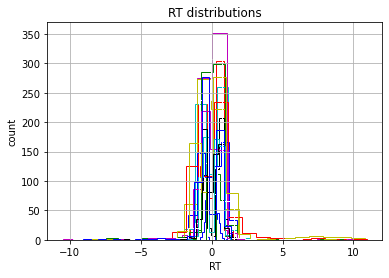

In [4]:
df_flip = hddm.utils.flip_errors(df)

# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df_flip.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_df_behav_ostwald.pdf')

### Multiple (better) ways to visualize the data in Python

#### First, visualize the summary data, as presented in the [preprint](https://www.biorxiv.org/content/10.1101/253047v1)

Here, we demonstrated two ways to visualize the data: bar plots (with error bar) and raincloud plots.

Before we jump into the plots, we can also check the number of trials for each condition of each participant.

In [5]:
df["cond"] = df["cue"] + "_" + df["coherence"]

# check the trials for accurate and wrong responses
df.groupby(['status', 'subj_idx', 'cue', 'coherence', 'accuracy']).size()

status   subj_idx  cue      coherence  accuracy
inside   2         invalid  high       0            3
                                       1           87
                            low        0           12
                                       1           75
                   valid    high       0            5
                                                   ..
outside  17        invalid  low        1           56
                   valid    high       0            1
                                       1           71
                            low        0           12
                                       1           60
Length: 247, dtype: int64

When visualize the data, we tried to replicate the Figure 2a in Georgie et al (2018). 

First, get the median of each condition for each participant, then, plot the mean and SD (instead of SE in the manuscript).

The plot looks like a bit different to the Fig 2a in the preprint.

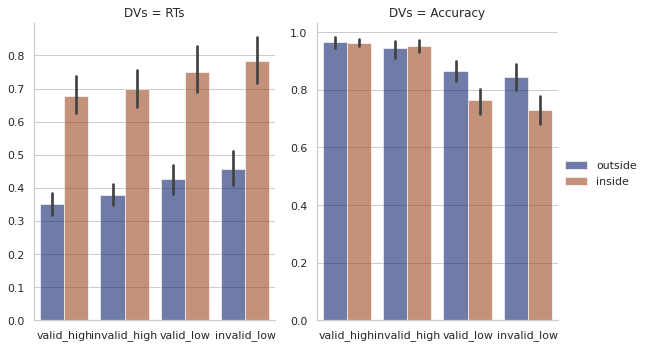

In [6]:
# get the median of accurate RTs
df_rt_sum = df[df['accuracy'] ==1].groupby(['subj_idx','status', 'cond'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
df_acc_sum = df.groupby(['subj_idx','status', 'cond'])['accuracy'].mean().reset_index()

# categorize the cond and order the data
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                           ordered=True)
df_rt_sum['cond'] = df_rt_sum['cond'].astype(cat_type)
df_acc_sum['cond'] = df_acc_sum['cond'].astype(cat_type)

df_rt_sum['DVs'] = 'RTs'
df_rt_sum.rename(columns={'rt':'value'}, inplace=True)
df_acc_sum['DVs'] = 'Accuracy'
df_acc_sum.rename(columns={'accuracy':'value'}, inplace=True)

df_sum = pd.concat([df_rt_sum, df_acc_sum]).reset_index(drop=True)  # concat two dataframes
df_sum['cond'] = df_sum['cond'].astype(cat_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=df_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='cond', y="value", hue = 'status', 
                order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

We can also used the [`raincloud` plot](https://wellcomeopenresearch.org/articles/4-63/v2), which shows both the individual data and group data.

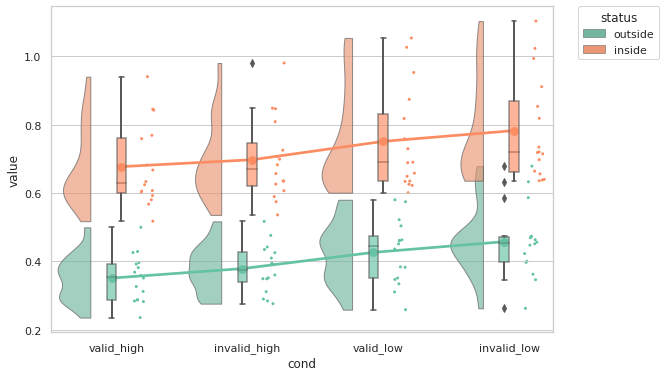

In [7]:
# plot raincloud of RT
import ptitprince as pt

dx = "cond"; dy = "value"; dhue = "status"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

We also need to visual inspect individual data. So we will plot individual data using interactive plots `plotly`.

In [8]:
df_p = df.set_index(['subj_idx'])
df_p.describe()

runid     condition   image_index          stim      response  \
count  10205.000000  10205.000000  10205.000000  10205.000000  10205.000000   
mean       2.326997      2.500441     36.362959      0.499461      0.524057   
std        1.333751      1.118571     20.778497      0.500024      0.499445   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%        1.000000      1.000000     19.000000      0.000000      0.000000   
50%        2.000000      3.000000     37.000000      0.000000      1.000000   
75%        3.000000      4.000000     54.000000      1.000000      1.000000   
max        5.000000      4.000000     72.000000      1.000000      1.000000   

                 rt      accuracy  stimulus_side  
count  10205.000000  10205.000000   10205.000000  
mean       0.705192      0.877413       0.500735  
std        0.746310      0.327979       0.500024  
min        0.000117      0.000000       0.000000  
25%        0.413091      1.000000       0.000000  
50%        0.593741      1.000000       1.000000  
75%        0.772207      1.000000       1.000000  
max       10.953051      1.000000       1.000000

In [9]:
# import packages and function for interactive plotting
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl
from plotly.graph_objs import *
import cufflinks as cf
init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
@interact(index_name=df_p.index.unique())  # can we use subject's number as the index_name?
def iplot_scale(index_name):
    df_tmp = df_p[df_p.index==index_name]['rt']
    iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 50,subplots=True, shape=(1, 1), filename='histogram-subplots'))

interactive(children=(Dropdown(description='index_name', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

#### Data pre-processing

As we can see from the above, some participant have extremely long Rts ( ~ 8 seconds). To avoid the problem in further analysis, we can remove the outliers. Note that there are multiple methods to remove outliers, here we choose Rousseeuw & Croux's measure of spread, $S_{n}$, as the critirion for excluding outliers in RT, as suggested by [Jones (2019, APP)](https://link.springer.com/article/10.3758/s13414-019-01726-3). 

We will define a function of $S_{n}$ based on [Jones (2019, APP)](https://link.springer.com/article/10.3758/s13414-019-01726-3), instead of use `robustbase` package directly. One importance difference between the two algorithm is whether or not use a constant multiplier.

* Note about $S_{n}$ method: this was implemented in python package [`robustbase`](https://github.com/deepak7376/robustbase), $S_{n}$

In [11]:
def Sn(x,finite_corr=True):
    """
    Sn scale estimator , Gaussian efficiency 58%
    Note, there is no constant as in the robustbase pacakge
    """
    import statistics
    import numpy as np
    import pandas as pd
    x = x.tolist() # convert to list
    n = len(x)

    if n==0:
        raise Exception("x sholud be non-empty !!!")
    if n==1:
        return 0
    
    med=[]
    for idx, val in enumerate(x):
        # remove the current value from the array
        if isinstance(x, pd.Series): # check if the input is a pandas series
            x_rest = x.drop(idx)
        else:
            x_rest = np.array(x[:idx] + x[idx+1 :])
        
        x_diff = x_rest - val  # calculate the differences between current value and the rest
        x_med = statistics.median(abs(x_diff)) # get the median of the absolute diffrences
        med.append(x_med)
    
    # choose the finite correction based on n 
    if n <= 9:
        bias_corr = [0, 0.743, 1.851, 0.954, 1.351, 0.993, 1.198, 1.005, 1.131][n-1]
    elif n > 9 & n % 2 == 1:  # n is odd
        bias_corr = n/(n-.9)
    else:             # n is even
        bias_corr = 1
    
    # calculate the Sn value
    Sn_value = round(bias_corr * statistics.median(med), 6) if finite_corr==True else round(statistics.median(med), 6)     
    Sn_values = np.array([Sn_value] * n)
    med_dist = np.array(med)
    return Sn_values, med_dist 

In [12]:
# calculate outliers based on participant
Sn_vals = []
med_dists = []
for sub in df["subj_idx"].unique():
#     print(sub)
#     for cond in df["status"].unique():
    tmp_rt = df.loc[(df["subj_idx"] ==sub)]["rt"]
#         print(len(tmp_rt))
    if (len(tmp_rt) ==0):
        continue
    else:  
        Sn_, med_ = Sn(tmp_rt)
    Sn_vals.append(Sn_)
    med_dists.append(med_)
        
Sn_vals = np.concatenate(Sn_vals, axis=0)
med_dists = np.concatenate(med_dists, axis=0)

# select valid data
df_v = df
df_v['Sn_vals'] = Sn_vals
df_v['med_dists'] = med_dists
df_v['Outliers'] = np.where(df_v['med_dists'] >= df_v['Sn_vals']*3, True, False)
df_v = df_v.loc[df_v['Outliers'] == False]

print(df_v.shape)
print("ratio of invalid trial 2 : ", (len(df) - len(df_v))/len(df))


(9750, 16)
ratio of invalid trial 2 :  0.044585987261146494


In [13]:
df_v = df_v.loc[df_v['rt'] >= 0.2]

In [14]:
print(df_v.shape)
df_v.head()

(9569, 16)


subj_idx   status  runid  condition      cue coherence  image_index  stim  \
0         1  outside      1          1    valid      high           19     1   
1         1  outside      1          2  invalid      high           12     0   
2         1  outside      1          2  invalid      high           20     1   
3         1  outside      1          1    valid      high            5     0   
4         1  outside      1          1    valid      high           13     0   

   response        rt  accuracy  stimulus_side          cond   Sn_vals  \
0         1  0.529206         1              0    valid_high  0.090001   
1         0  0.519501         1              0  invalid_high  0.090001   
2         1  0.611204         1              0  invalid_high  0.090001   
3         0  0.465089         1              0    valid_high  0.090001   
4         0  0.367166         1              1    valid_high  0.090001   

   med_dists  Outliers  
0   0.110997     False  
1   0.105250     False  
2   0.178164     False  
3   0.082345     False  
4   0.080289     False

In [15]:
#df_p2.columns = df_p2.columns.get_level_values(0)

df_p2 = df_v
df_p2 = df_p2.set_index(['subj_idx'])
df_p2.describe()

runid    condition  image_index         stim     response  \
count  9569.000000  9569.000000  9569.000000  9569.000000  9569.000000   
mean      2.317797     2.497544    36.288640     0.499321     0.525029   
std       1.336575     1.119164    20.796144     0.500026     0.499399   
min       1.000000     1.000000     1.000000     0.000000     0.000000   
25%       1.000000     1.000000    18.000000     0.000000     0.000000   
50%       2.000000     2.000000    36.000000     0.000000     1.000000   
75%       3.000000     4.000000    54.000000     1.000000     1.000000   
max       5.000000     4.000000    72.000000     1.000000     1.000000   

                rt     accuracy  stimulus_side      Sn_vals    med_dists  
count  9569.000000  9569.000000    9569.000000  9569.000000  9569.000000  
mean      0.609635     0.886718       0.501202     0.215854     0.244725  
std       0.252925     0.316954       0.500025     0.064742     0.114910  
min       0.200154     0.000000       0.000000     0.089582     0.063635  
25%       0.414805     1.000000       0.000000     0.178637     0.166487  
50%       0.586844     1.000000       1.000000     0.185777     0.217342  
75%       0.744328     1.000000       1.000000     0.242336     0.293805  
max       1.778961     1.000000       1.000000     0.341696     1.019027

In [16]:
@interact(index_name=df_p2.index.unique())  # can we use subject's number as the index_name?
def iplot_scale(index_name):
    df_tmp = df_p2[df_p2.index==index_name]['rt']
    iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 50,subplots=True, shape=(1, 1), filename='histogram-subplots'))

interactive(children=(Dropdown(description='index_name', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

In [17]:
df_v.to_csv('df_PDM_v.csv')

## Traditional analyses (optional in the future, can be removed)

In case we also want to use traditional Bayesian hierarchical model using `pymc3` and [`bambi`](https://github.com/bambinos/bambi), e.g., using signal detection theory to model accuracy and `shifted log normal` to model RTs. So I tested these tools inside this docker image, using `bambi`'s example.

In [18]:
import bambi as bmb
import arviz as az

# # check whether bambi works
# data = pd.DataFrame({
#     "y": np.random.normal(size=50),
#     "g": np.random.choice(["Yes", "No"], size=50),
#     "x1": np.random.normal(size=50),
#     "x2": np.random.normal(size=50)
# })

# # Test the bambi package
# model = bmb.Model(data)
# fitted = model.fit("y ~ x1 + x2")

# az.plot_trace(fitted)

In [19]:
# az.summary(fitted)

## HDDM analyses

Now, we will start to use HDDM to model the data. Note that we skipped *prior predictive check*, *parameter recovery*.

### Model building

Here we can choose between `HDDM`, `HDDMStimCoding`, and `HDDMRegressor`, for each model, we can also choose how many parameters are free to vary across condition. 

We assume that boundary separation `a` and initial bias `z` do not vary across conditions (attentional cue and difficulty). Therefore we focused on the rest two parameters `v` and `t`. We hypothesize that (1) drift rate is modualted by task difficulty but to a less extend attention prioritization (Ratcliff & Mckoon, 2008), and (2) nondecision time is influenced by attention (Price, et al, 2019, Bio Psychiat) and status (inside vs. outside scanner) but not task difficulty.

We will build three models to test these hyotheses:
* M1: $v \sim cue + coherence + status$
* M2: $t \sim cue + coherence + status$
* M3: $v \sim cue + coherence + status, t \sim cue + coherence + status$

Because the data itself is a within-subject design, it's recommended by tutorial to use `HDDMRegressor` function, and we assume that `HDDMRegressor` is the best model in this case (Here parameter recovery can be used for model selection before we applying models to data). Below, we define three models using three functions for later parallel processing:

In [22]:
def run_m1(id):
    import hddm

    exp_name = 'PDM_v'
    model_tag = 'm1_v_reg'
    print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    # note: if Treatment() argument is not specified, it will be automatically order by alphbetical
    v_reg = {'model': "v ~ 1 + C(status) * C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    
    m = hddm.HDDMRegressor(df, v_reg, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(10000, burn=200, dbname=dbname, db='pickle')

    m.save(mname)
    return m

def run_m2(id):
    import hddm

    exp_name = 'PDM_v'
    model_tag = 'm2_t_reg'
    print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    t_reg = {'model': "t ~ 1 + C(status) * C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    
    m = hddm.HDDMRegressor(df, t_reg, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(10000, burn=200, dbname=dbname, db='pickle')

    m.save(mname)
    return m

def run_m3(id):
    # print('running model%i'%id);
    import hddm
    # import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = 'PDM_v'
    model_tag = 'm3_vt_reg'
    print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    v_reg = {'model': "v ~ 1 + C(status) * C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    t_reg = {'model': "t ~ 1 + C(status) * C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    reg_descr = [v_reg, t_reg]
    
    m = hddm.HDDMRegressor(df, reg_descr, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(10000, burn=2000, dbname=dbname, db='pickle')
       
#     m = hddm.HDDM(df,
#                   include= ['v', 'a', 't', 'z'],
#                   depends_on={'v':['status','cue','coherence'], 
#                               'a':['status','cue','coherence'],
#                               't':['status','cue','coherence']},
#                   p_outlier = .05)
    
#     m.find_starting_values()
#     m.sample(5000, burn=1000, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [23]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

Using `ipyparallel` for parallel processing, please make sure that you have started multiple engines at the `IPython Cluster` tag.

In [ ]:
# run M1 in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m1, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M1s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
721.017s elapsed

running models 0 for  PDM_v   m1_v_reg
Adding these covariates:
['v_Intercept', 'v_C(status)[T.outside]', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", 'v_C(status)[T.outside]:C(cue)[T.valid]', "v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
 [---               8%                  ] 857 of 10000 complete in 714.7 sec
running models 1 for  PDM_v   m1_v_reg
Adding these covariates:
['v_Intercept', 'v_C(status)[T.outside]', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", 'v_C(status)[T.outside]:C(cue)[T.valid]', "v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
 [---               8%              

In [16]:
# run M2s in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m2, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M2s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Running 4 chains used: 19780.177266 seconds.


In [17]:
# run M3s in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m3, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M3s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Running 4 chains used: 45411.371736 seconds.


### Check convegence

As mentioned in the tutorial, there are multiple ways to check the convegence of sampling of the models. 

#### Look at MC error statistic

MC error should not be smaller than 1% of the posterior std, however, this statistic is very weak and not sufficient

To check all four chains together, we can concat them together using `concat_models`:

In [18]:
M1s_comb = kabuki.utils.concat_models(M1s)
M2s_comb = kabuki.utils.concat_models(M2s)
M3s_comb = kabuki.utils.concat_models(M3s)

In [19]:
stats = M1s_comb.gen_stats()
stats

mean        std  \
a                                                     1.33302  0.0484193   
a_std                                                0.193657  0.0398152   
a_subj.1                                             0.972967  0.0289444   
a_subj.2                                                1.032  0.0269011   
a_subj.3                                              1.31426   0.025827   
...                                                       ...        ...   
v_C(coherence, Treatment('low'))[T.high]            -0.099541  0.0508232   
v_C(status)[T.outside]:C(cue)[T.valid]              0.0474131  0.0909999   
v_C(status)[T.outside]:C(coherence, Treatment('...  0.0374908  0.0965536   
v_C(cue)[T.valid]:C(coherence, Treatment('low')...  0.0422703  0.0722466   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere... -0.0416766   0.139453   

                                                         2.5q         25q  \
a                                                     1.24123     1.30107   
a_std                                                0.133649    0.165526   
a_subj.1                                             0.917632    0.953663   
a_subj.2                                              0.98052     1.01374   
a_subj.3                                              1.26481     1.29676   
...                                                       ...         ...   
v_C(coherence, Treatment('low'))[T.high]            -0.199612   -0.133906   
v_C(status)[T.outside]:C(cue)[T.valid]              -0.131472  -0.0139905   
v_C(status)[T.outside]:C(coherence, Treatment('...  -0.152021  -0.0276665   
v_C(cue)[T.valid]:C(coherence, Treatment('low')... -0.0983936 -0.00658944   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere...  -0.313771    -0.13621   

                                                          50q        75q  \
a                                                     1.33178    1.36336   
a_std                                                0.187514   0.215128   
a_subj.1                                             0.972705   0.992134   
a_subj.2                                               1.0315    1.04991   
a_subj.3                                              1.31386    1.33128   
...                                                       ...        ...   
v_C(coherence, Treatment('low'))[T.high]           -0.0994655 -0.0650861   
v_C(status)[T.outside]:C(cue)[T.valid]              0.0475936   0.108836   
v_C(status)[T.outside]:C(coherence, Treatment('...  0.0368606   0.102343   
v_C(cue)[T.valid]:C(coherence, Treatment('low')...  0.0423929   0.090915   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere... -0.0423613   0.052866   

                                                          97.5q       mc err  
a                                                       1.43286  0.000211824  
a_std                                                  0.288881  0.000189004  
a_subj.1                                                1.03009  0.000189733  
a_subj.2                                                1.08576  0.000135794  
a_subj.3                                                1.36654   0.00012544  
...                                                         ...          ...  
v_C(coherence, Treatment('low'))[T.high]           -0.000466869  0.000748702  
v_C(status)[T.outside]:C(cue)[T.valid]                 0.224175   0.00118933  
v_C(status)[T.outside]:C(coherence, Treatment('...     0.227654   0.00139315  
v_C(cue)[T.valid]:C(coherence, Treatment('low')...     0.184085  0.000964767  
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere...     0.232626   0.00181311  

[83 rows x 8 columns]

#### Geweke stastics

The Geweke statistic is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain. You can test your model by running:

In [20]:
# from kabuki.analyze import check_geweke
kabuki.analyze.check_geweke(M1s[3], assert_=False)

Chain of knode_name             a_std
stochastic              True
observed               False
subj                   False
node                   a_std
tag                       ()
depends                   []
hidden                 False
subj_idx                 NaN
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
mean                0.193489
std                 0.039235
2.5q                0.134216
25q                 0.165559
50q                 0.187738
75q                 0.214863
97.5q               0.287896
mc err           0.000402631
Name: a_std, dtype: object not properly converged


False

In [21]:
kabuki.analyze.check_geweke(M2s[3], assert_=False)

Chain of knode_name            a_subj
stochastic              True
observed               False
subj                    True
node                a_subj.1
tag                       ()
depends           [subj_idx]
hidden                 False
subj_idx                   1
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
mean                0.900425
std                0.0260597
2.5q                0.851489
25q                 0.882354
50q                 0.899637
75q                 0.917326
97.5q               0.954243
mc err           0.000426133
Name: a_subj.1, dtype: object not properly converged


False

In [22]:
kabuki.analyze.check_geweke(M3s_comb, assert_=False)

Chain of knode_name             a_std
stochastic              True
observed               False
subj                   False
node                   a_std
tag                       ()
depends                   []
hidden                 False
subj_idx                 NaN
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
mean                0.148138
std                0.0309266
2.5q                0.101929
25q                 0.126584
50q                  0.14354
75q                  0.16435
97.5q               0.221309
mc err           0.000177784
Name: a_std, dtype: object not properly converged


False

#### Visually insepct chains

Given that we have four chains sampled independently, we can plot them and check how they converge. This is not mentioned in previous tutorials but is a common practice for today's Baysian analysis

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(status)[T.outside]
Plotting v_C(cue)[T.valid]
Plotting v_C(coherence, Treatment('low'))[T.high]
Plotting v_C(status)[T.outside]:C(cue)[T.valid]
Plotting v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]
Plotting v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]
Plotting v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


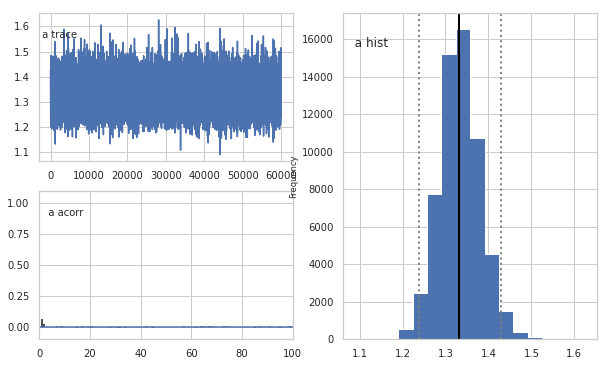

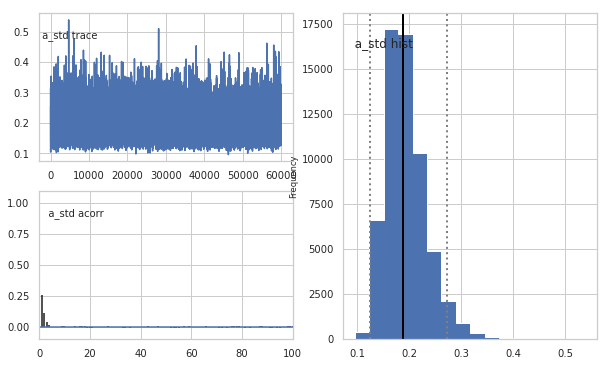

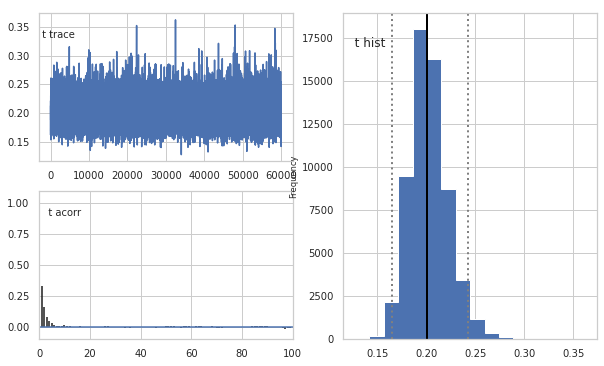

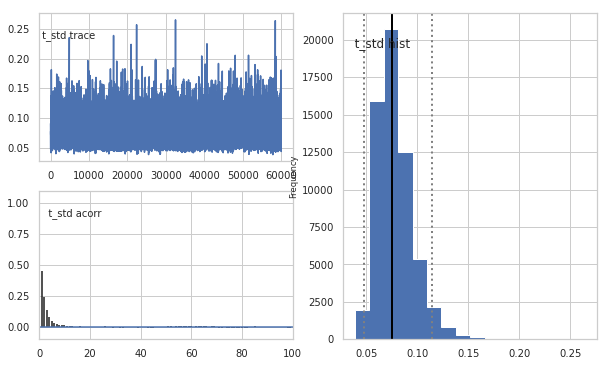

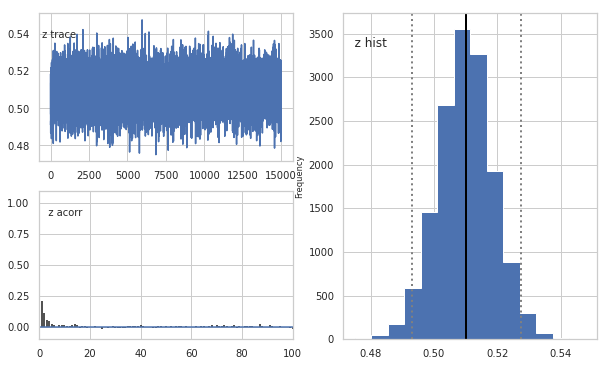

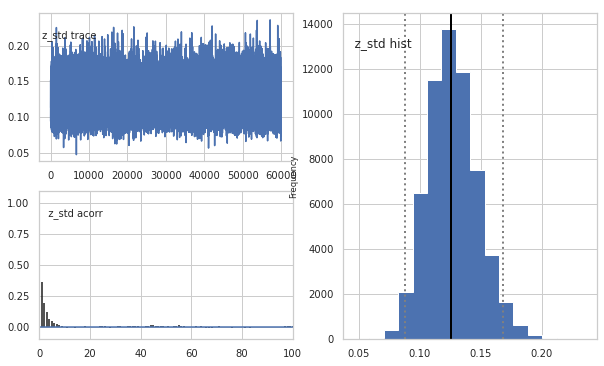

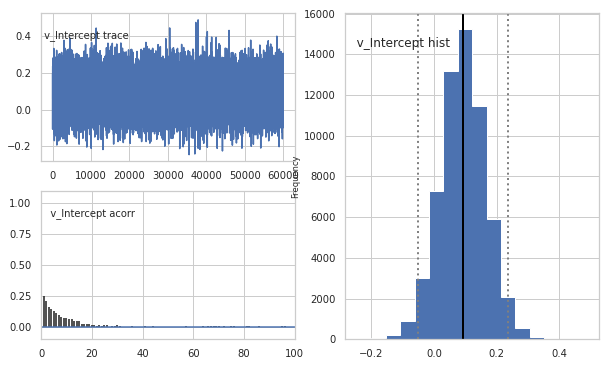

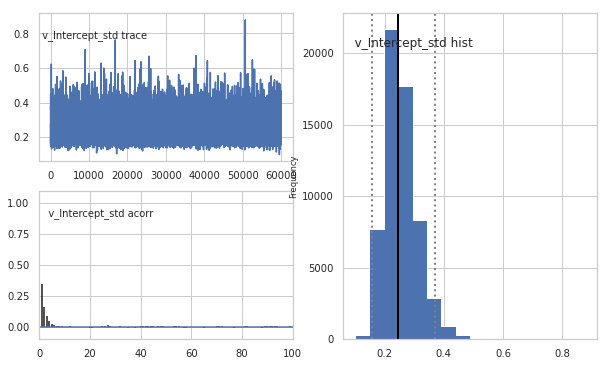

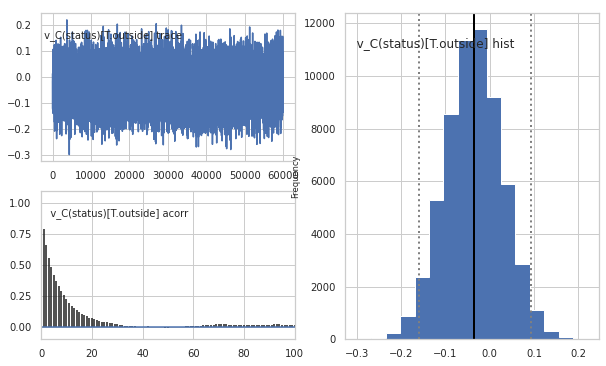

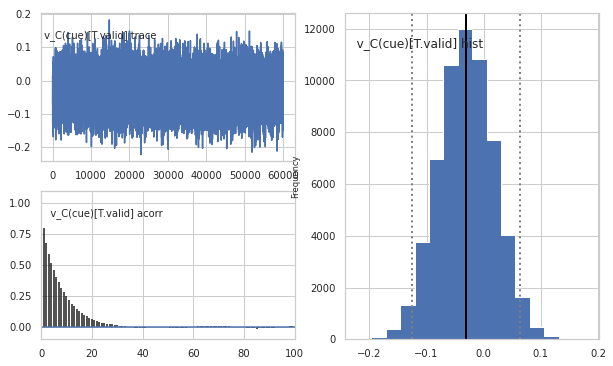

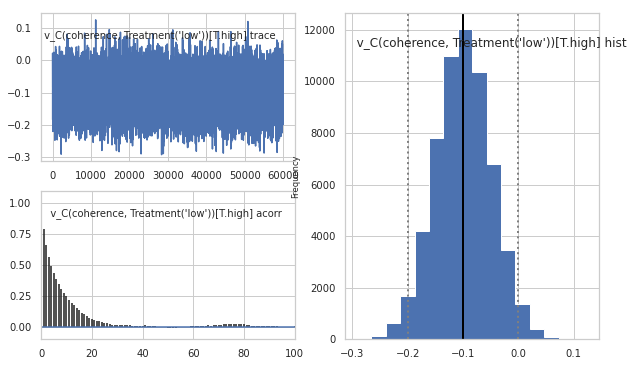

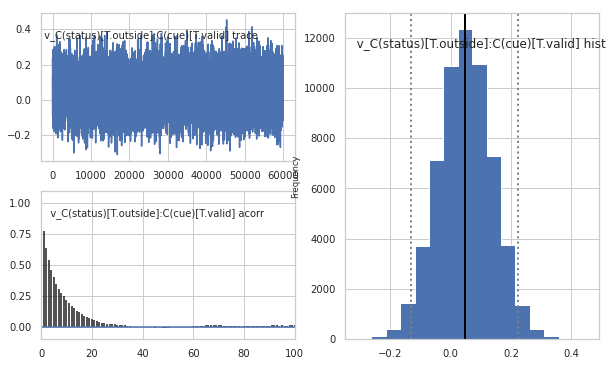

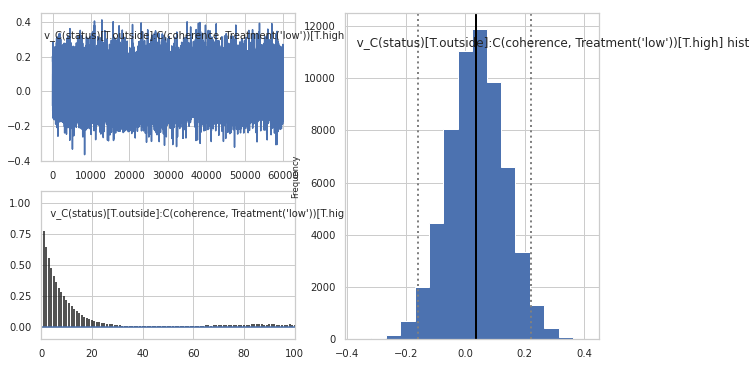

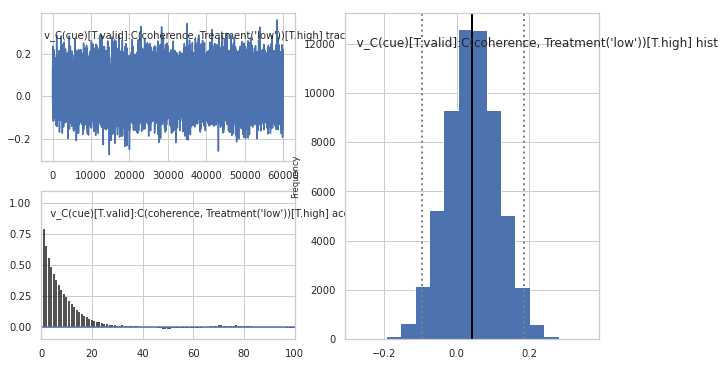

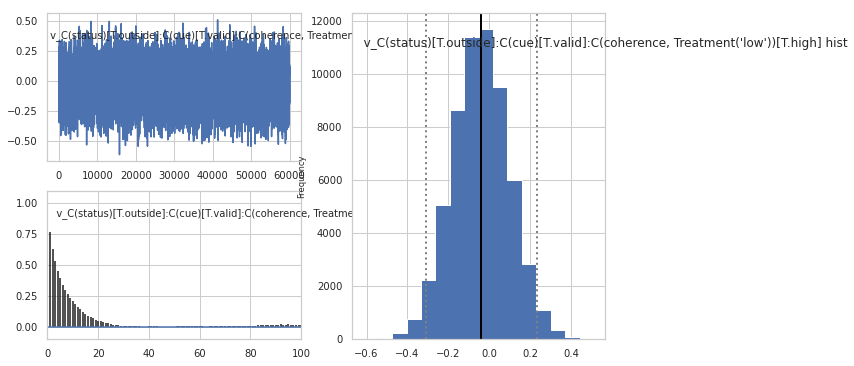

In [23]:
M1s_comb.plot_posteriors()

In [24]:
def plot_grp_trace(models, param=None):
    '''
    This function is to plot the traces of one of DDM params
    If param is None, than, will plot all the group parameters' posterior.
    '''
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    if param is not None:
        filter_col = [col for col in df_grp_traces if col.startswith(param)]
        filter_col.append('chain') # add the chain column to the data
    else:
        filter_col = [col for col in df_grp_traces]
            
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')
        
        sns.kdeplot(data=df_tmp, x="value", hue="chain", ax=axs[1], palette='Set2',
                    shade=False, linewidth=3)

        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)
a


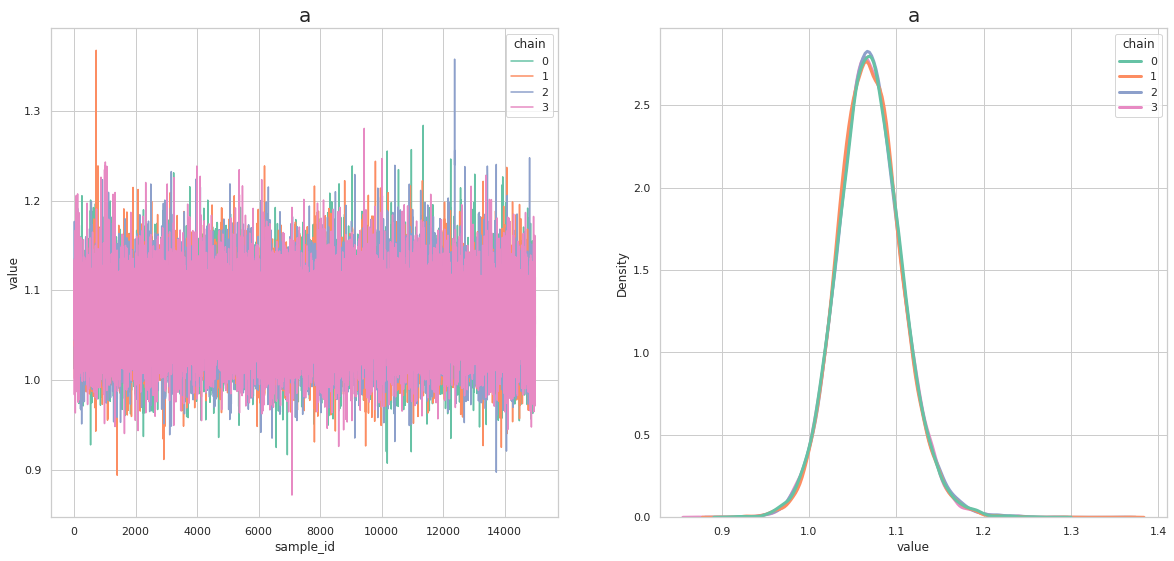

a_std


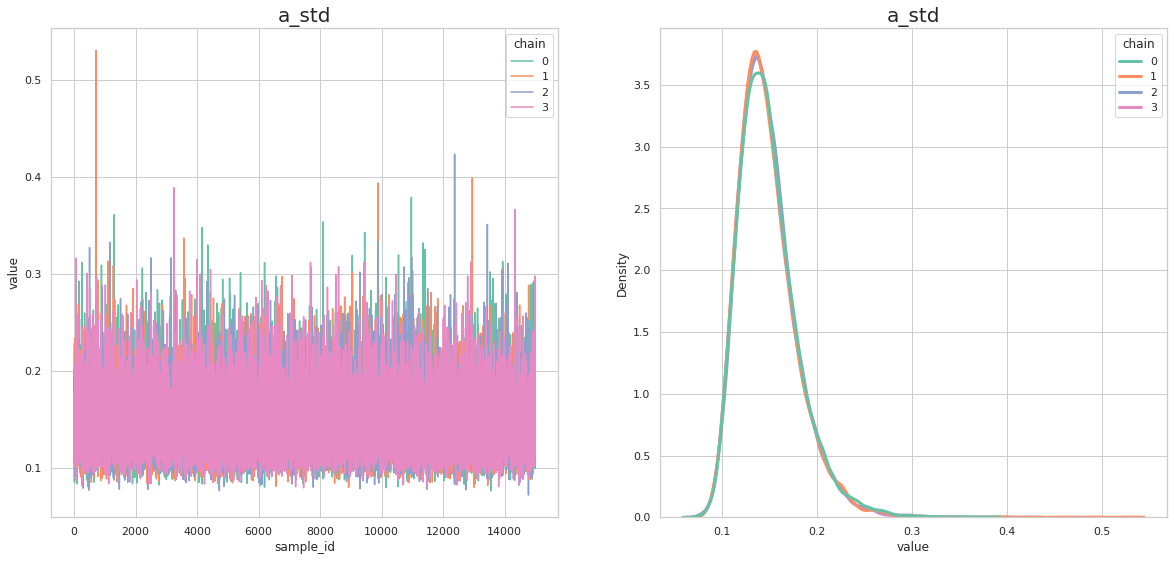

t_C(coherence, Treatment('low'))[T.high]


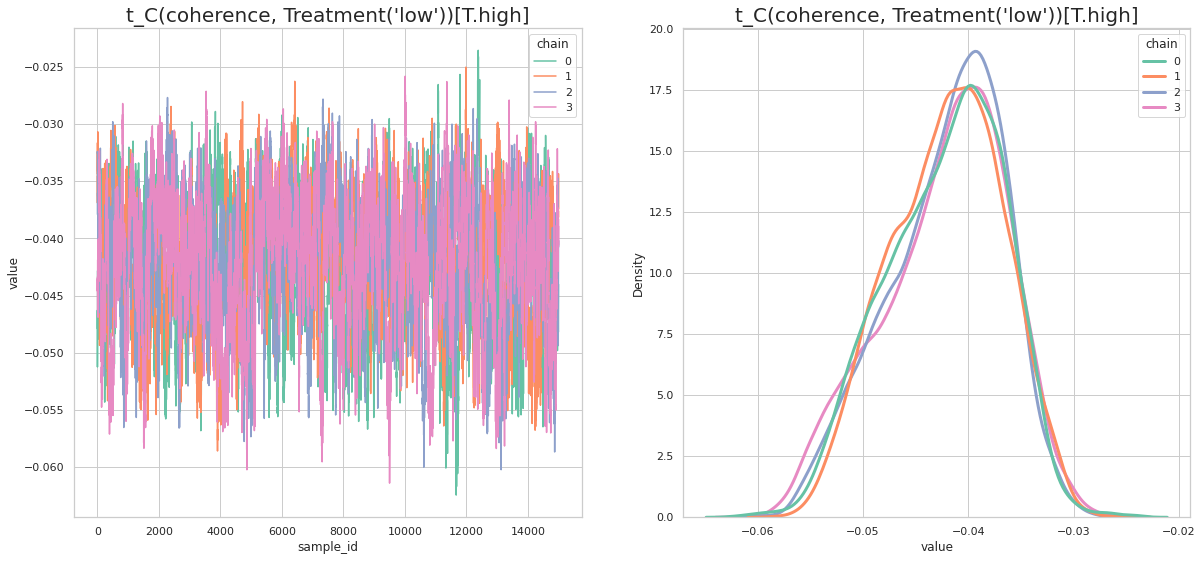

t_C(cue)[T.valid]


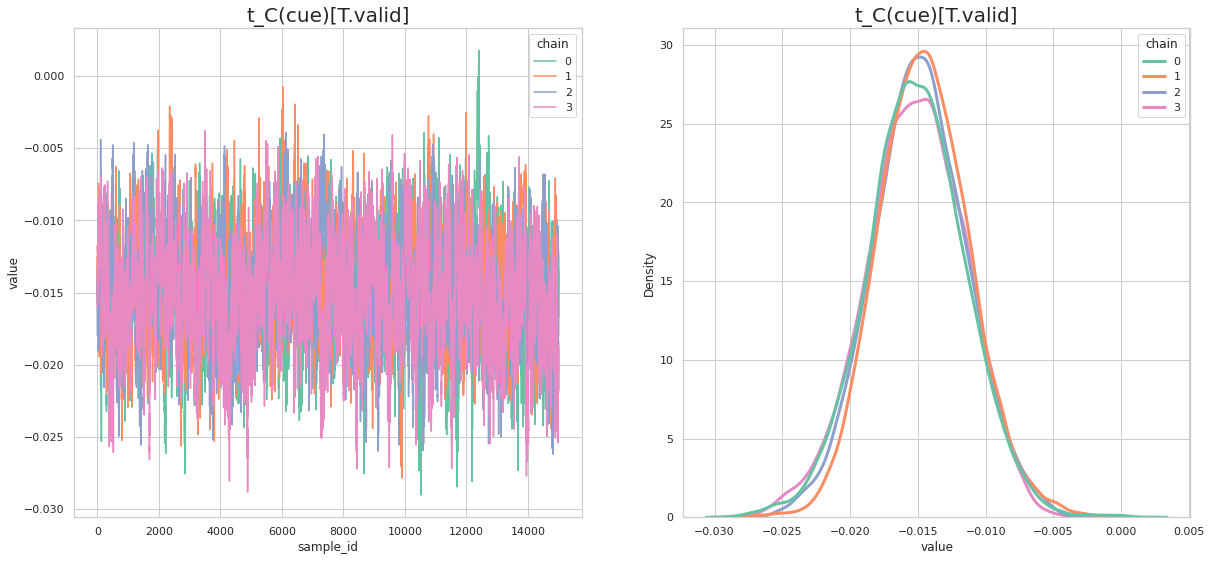

t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


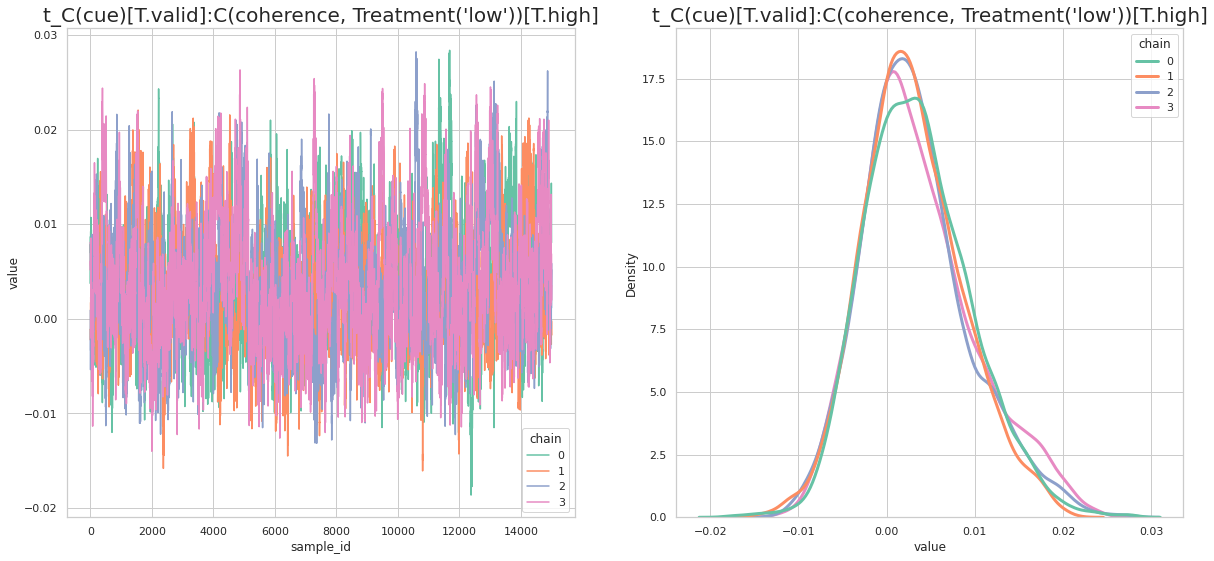

t_C(status)[T.outside]


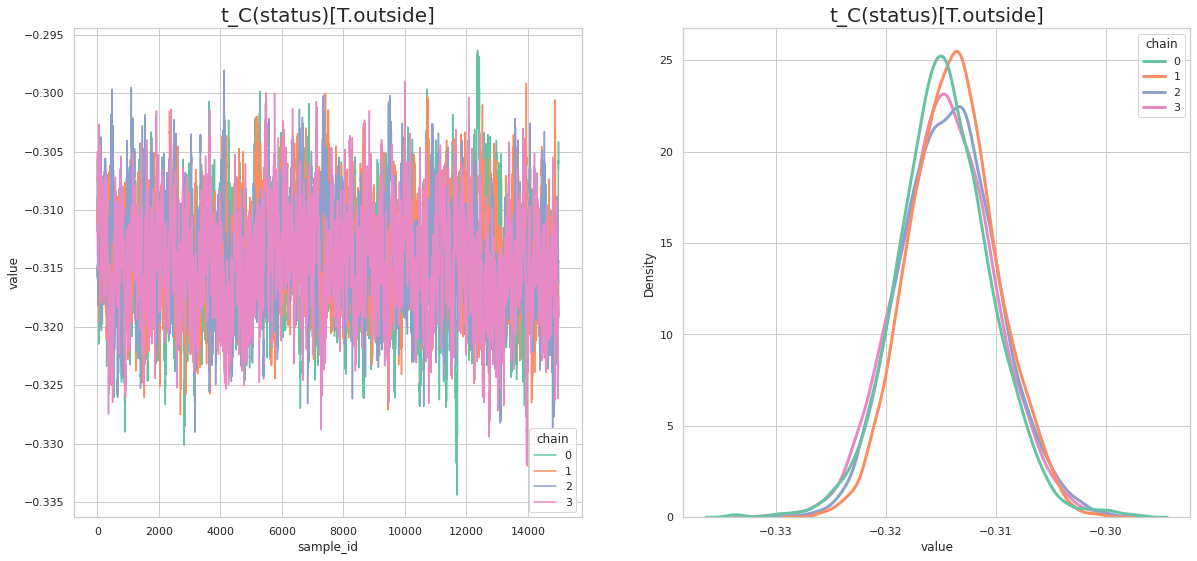

t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


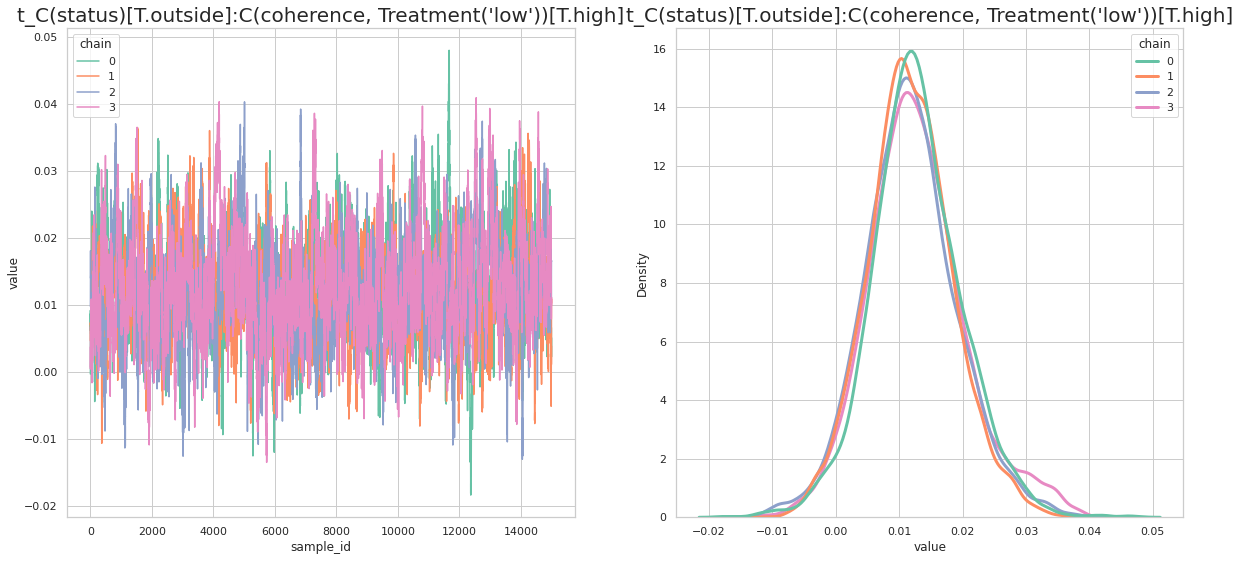

t_C(status)[T.outside]:C(cue)[T.valid]


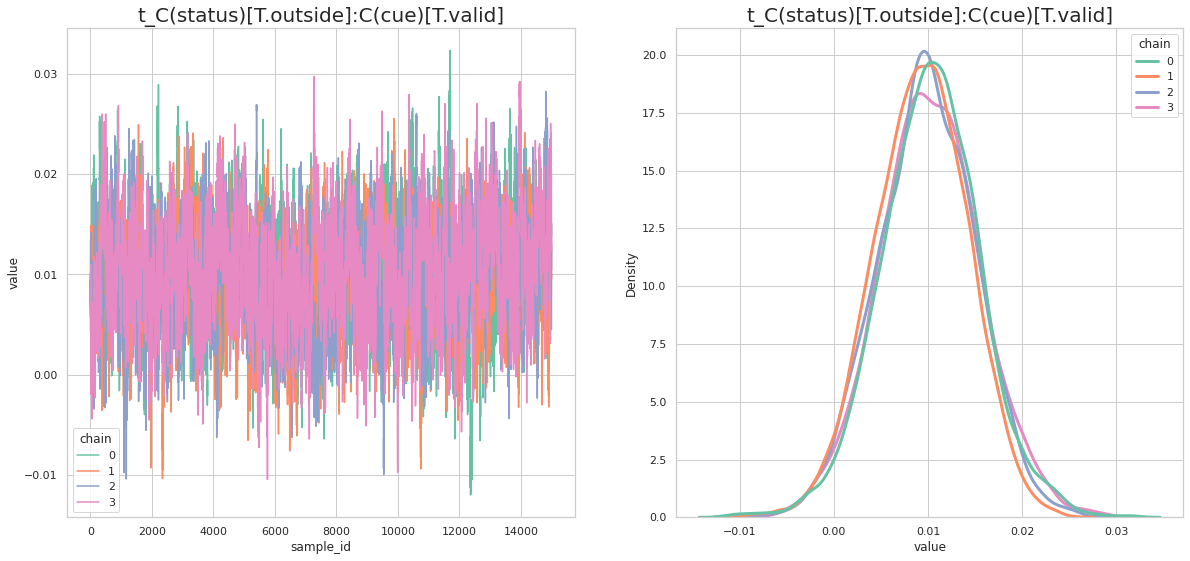

t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


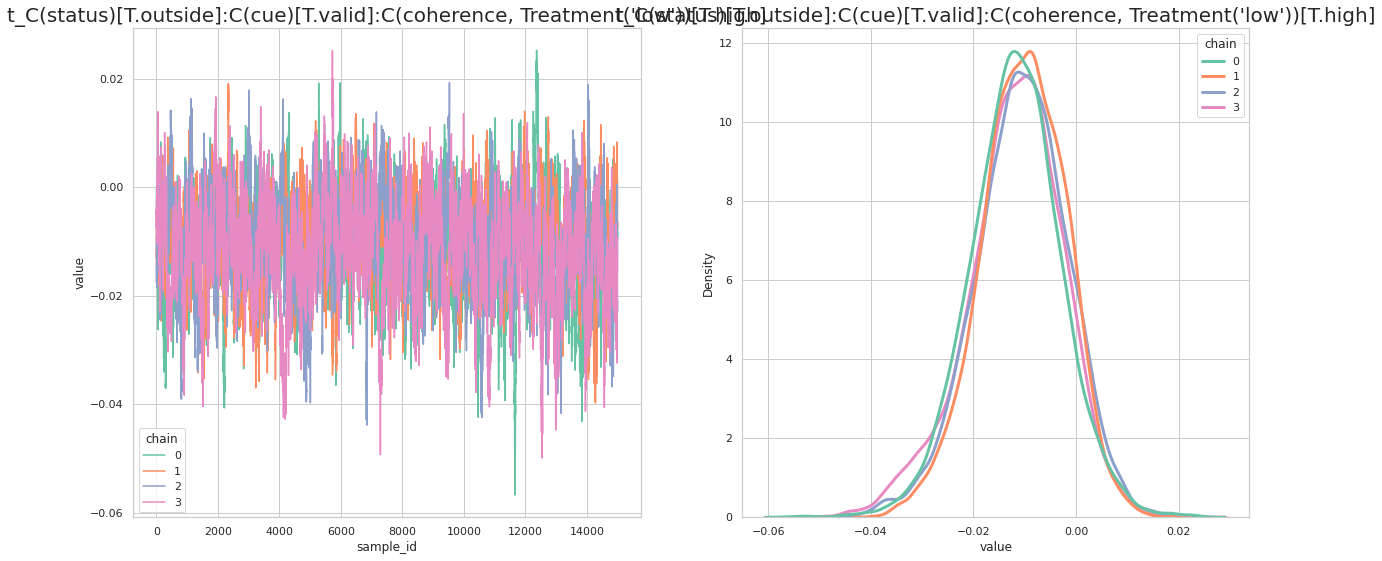

t_Intercept


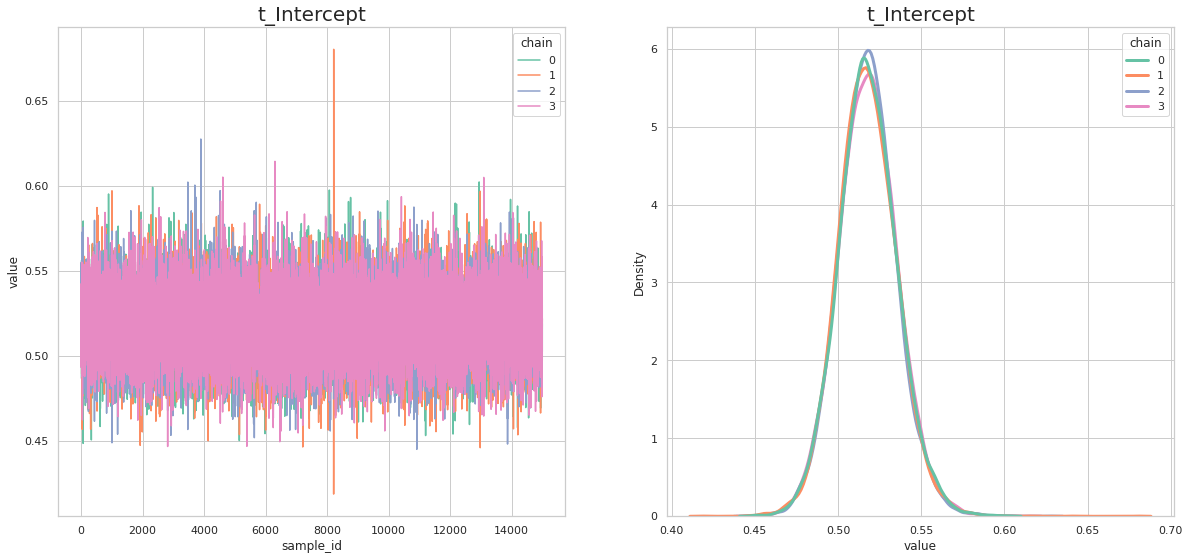

t_Intercept_std


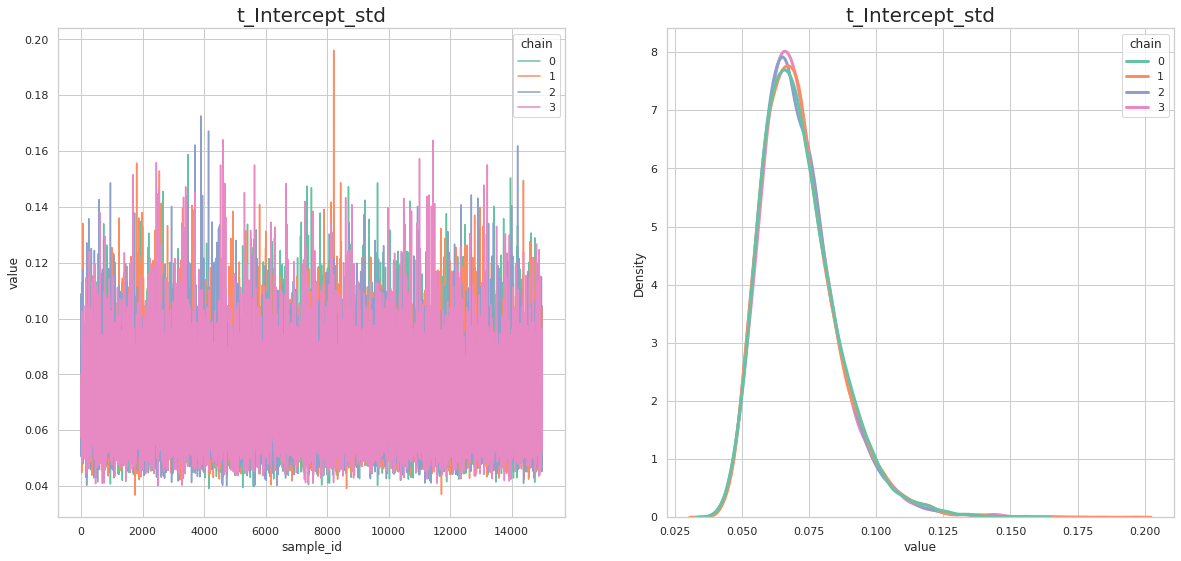

v_C(coherence, Treatment('low'))[T.high]


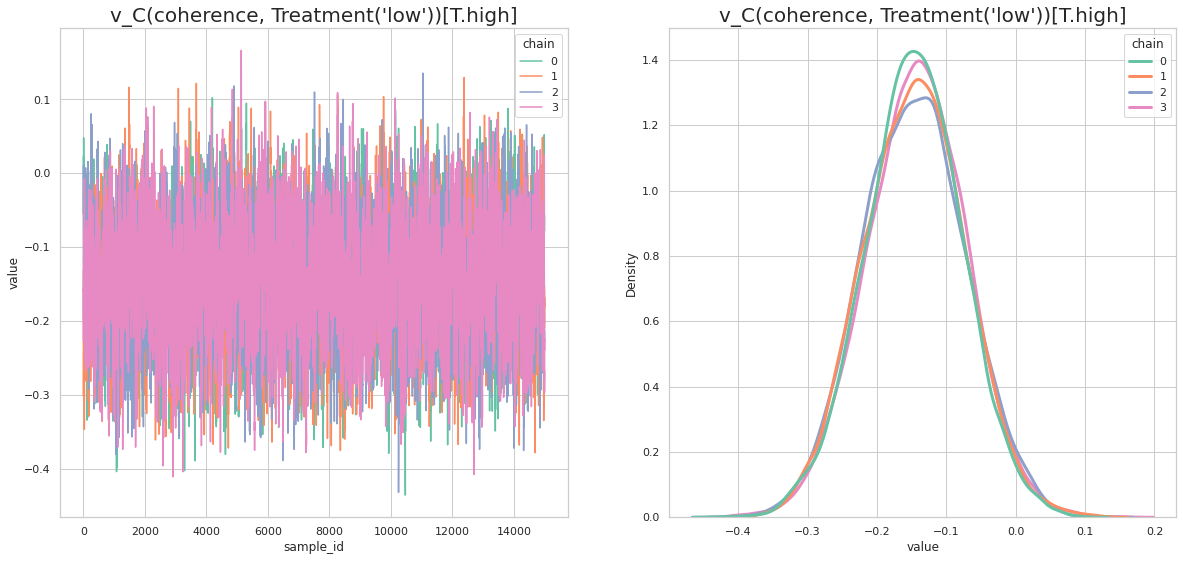

v_C(cue)[T.valid]


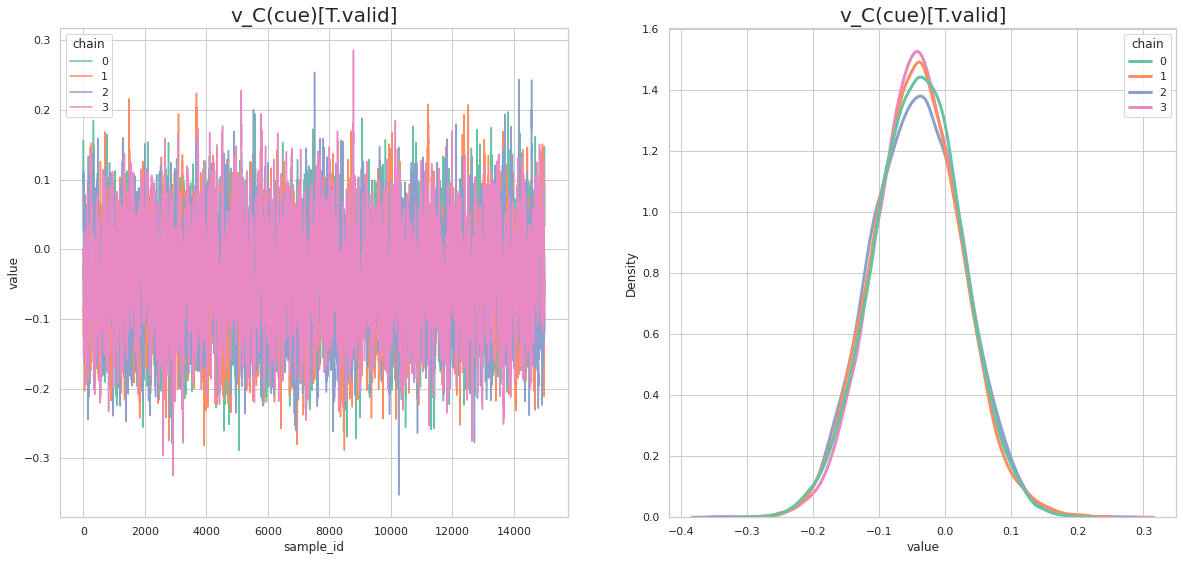

v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


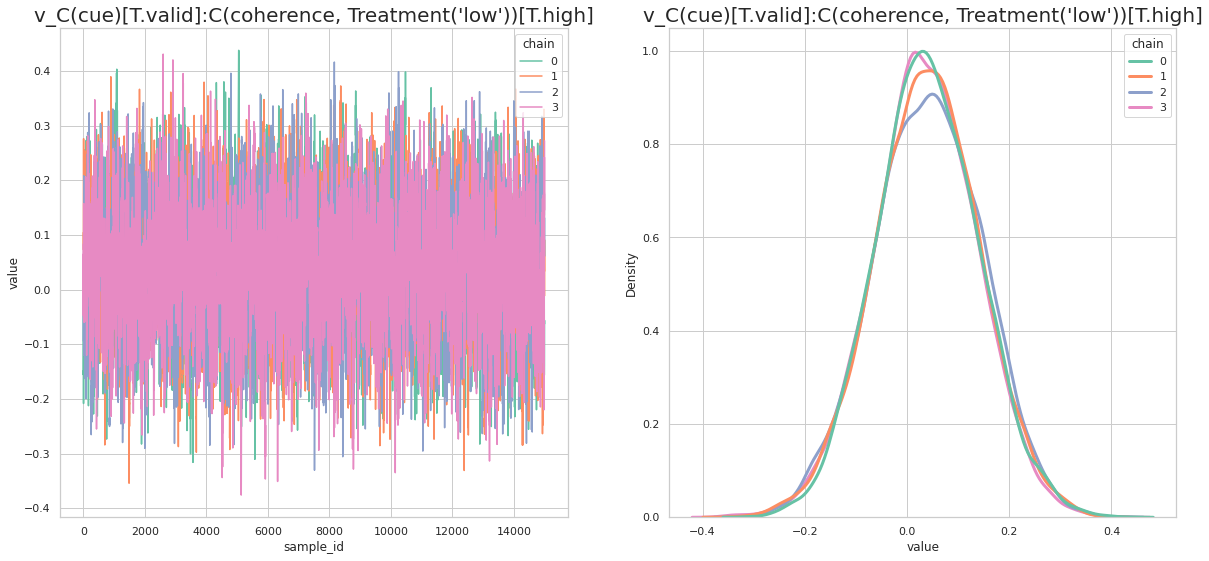

v_C(status)[T.outside]


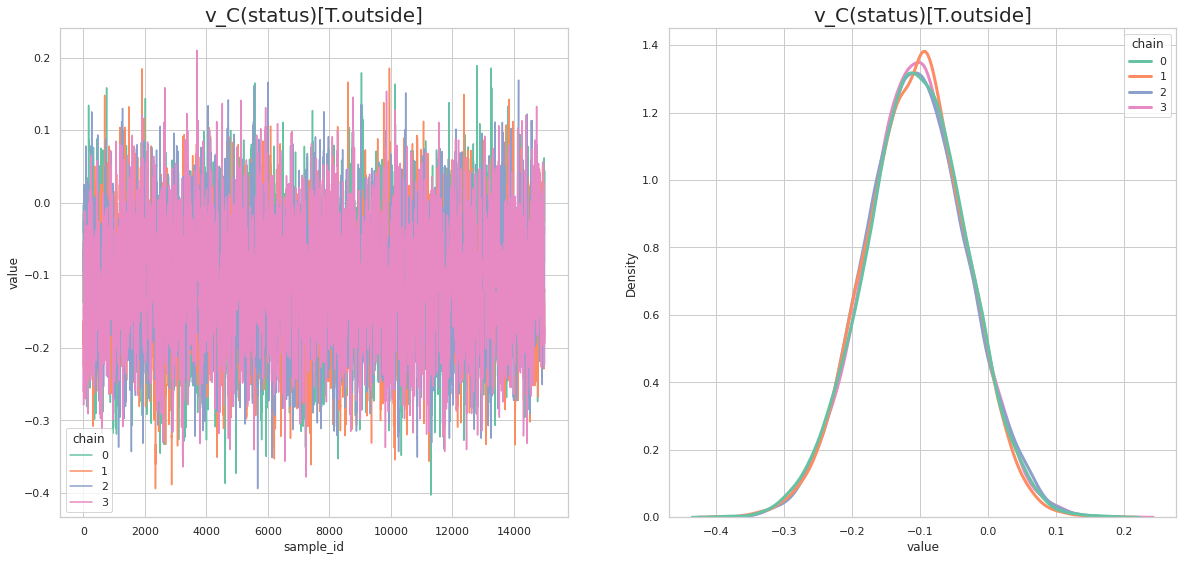

v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


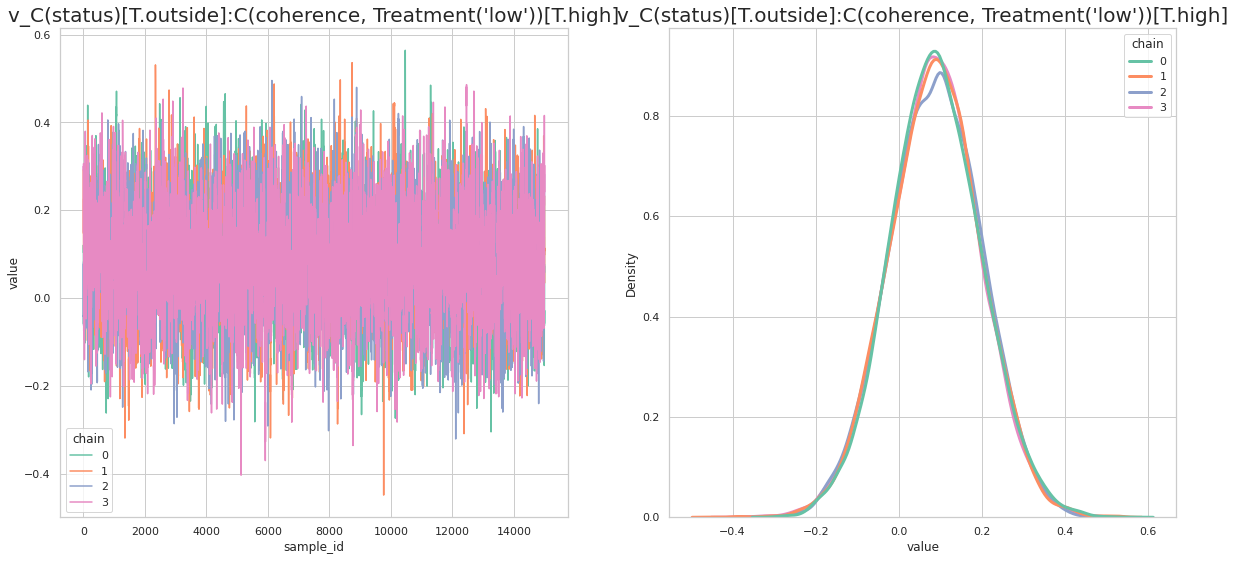

v_C(status)[T.outside]:C(cue)[T.valid]


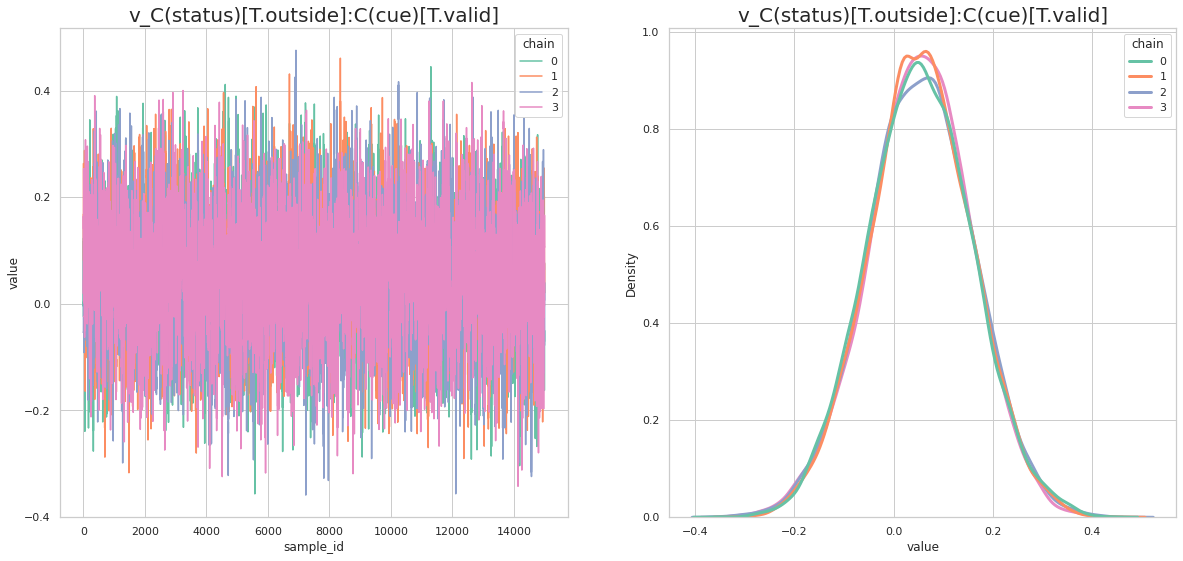

v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


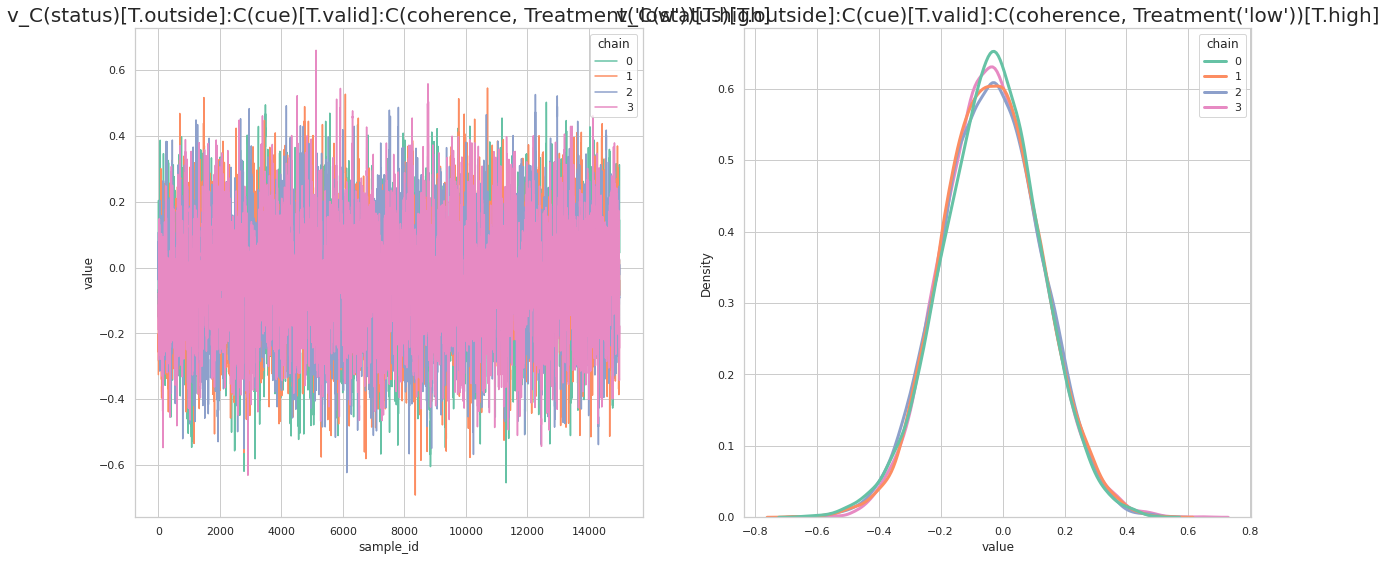

v_Intercept


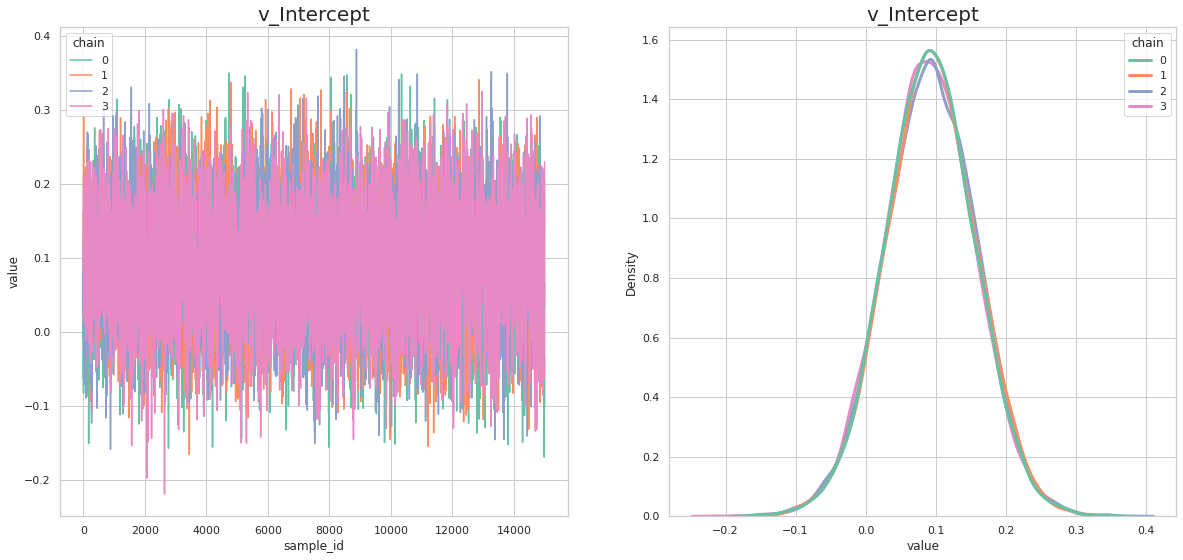

v_Intercept_std


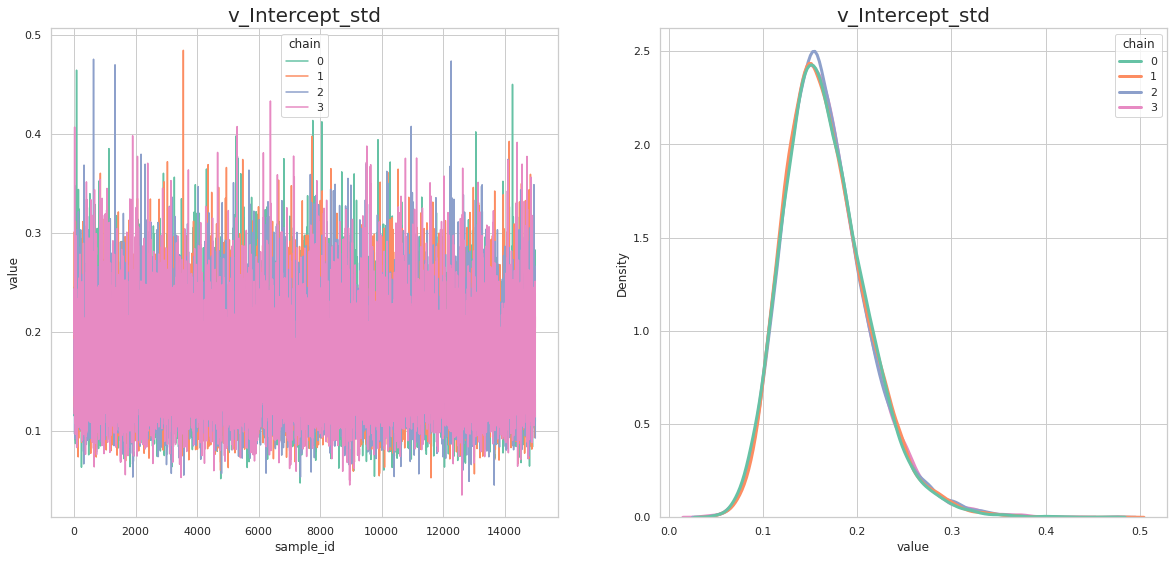

z_std


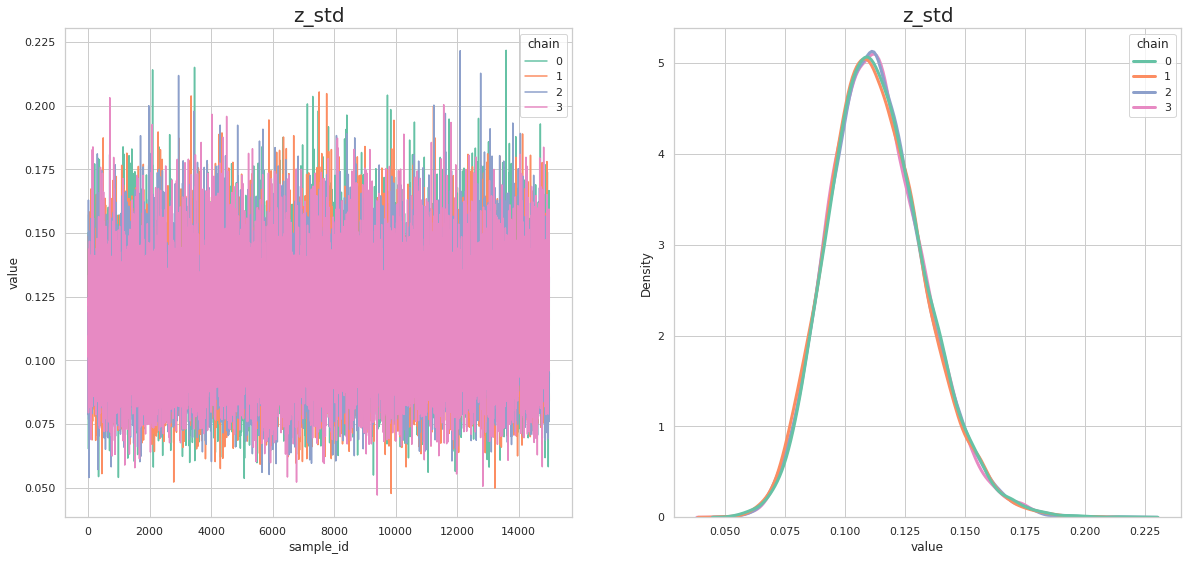

z_trans


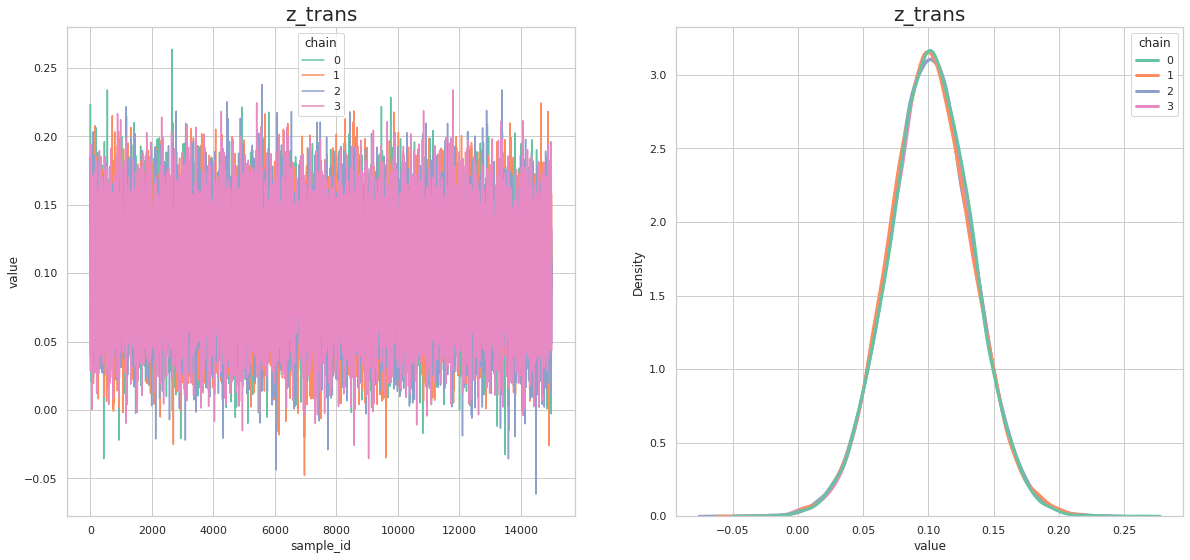

In [25]:
plot_grp_trace(models=M3s)

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)
t_C(coherence, Treatment('low'))[T.high]


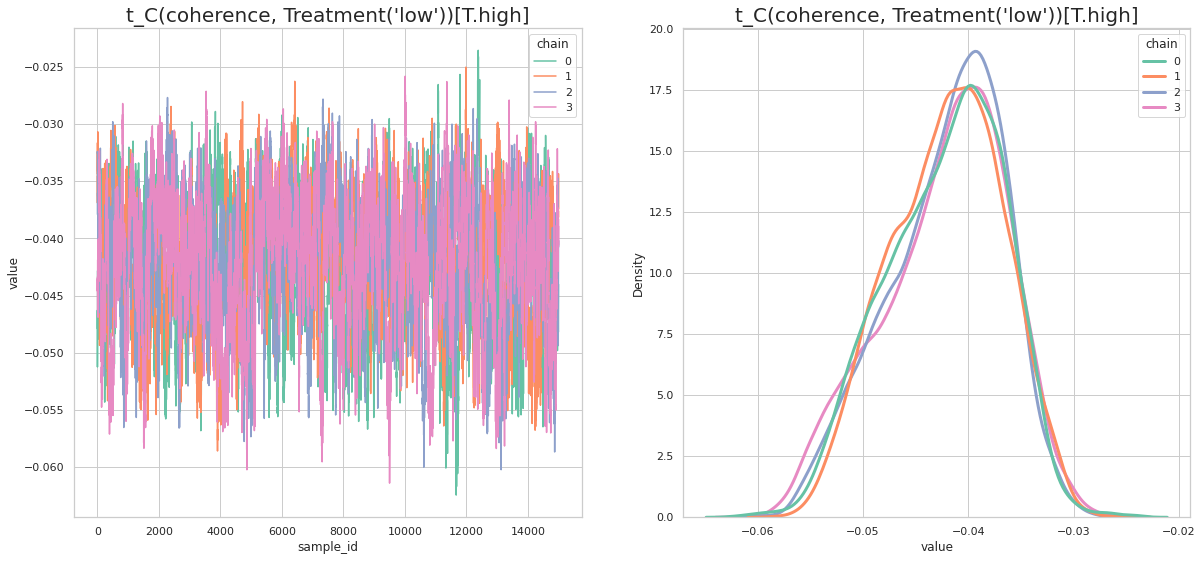

t_C(cue)[T.valid]


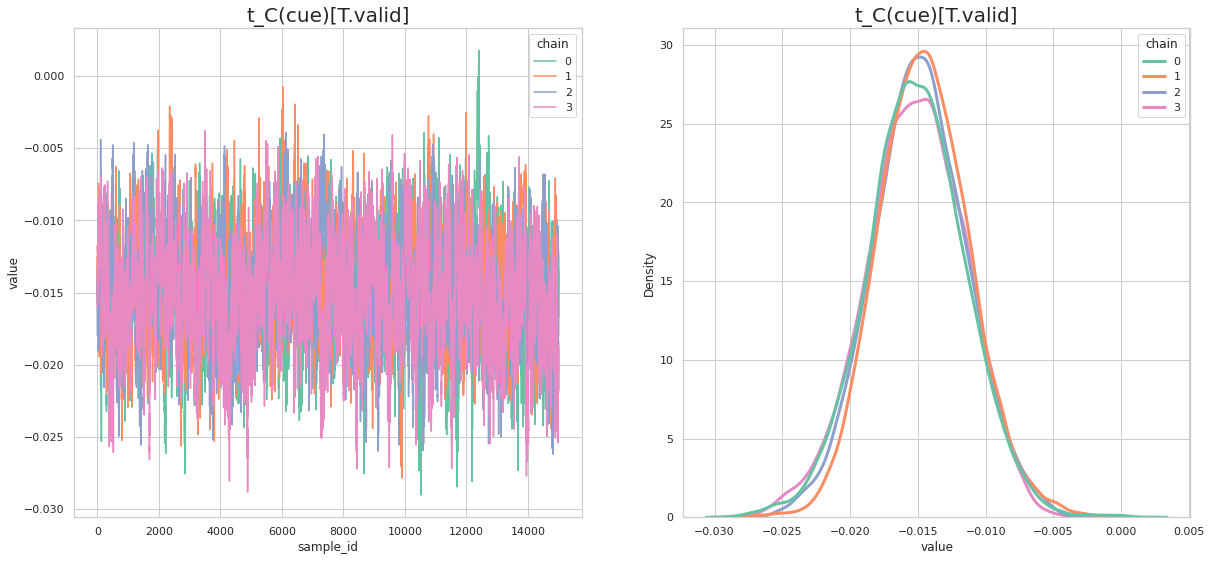

t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


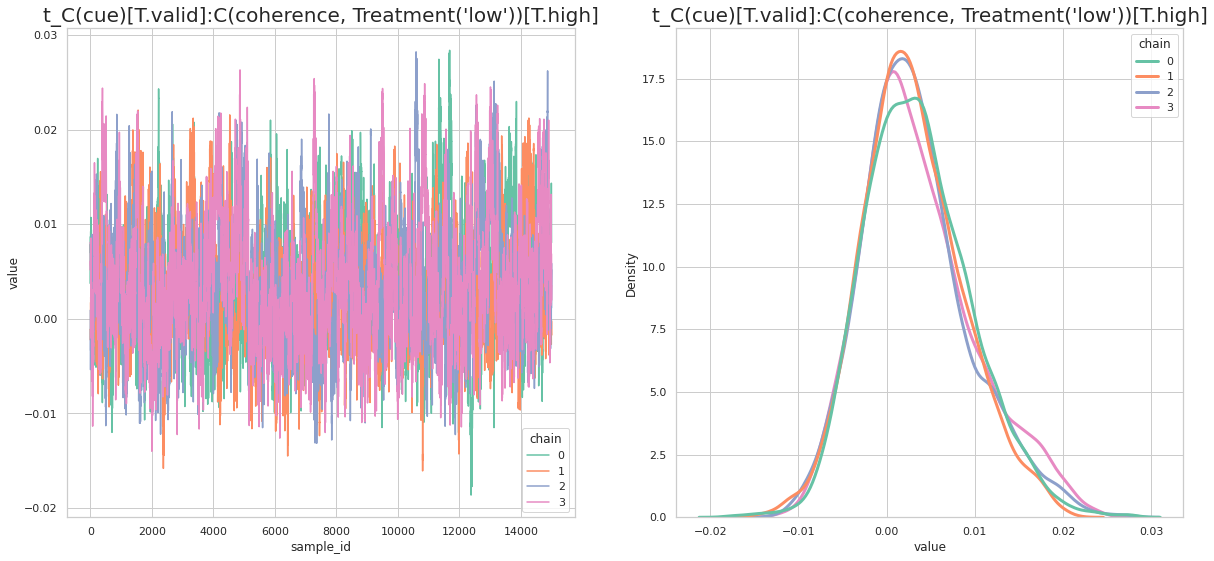

t_C(status)[T.outside]


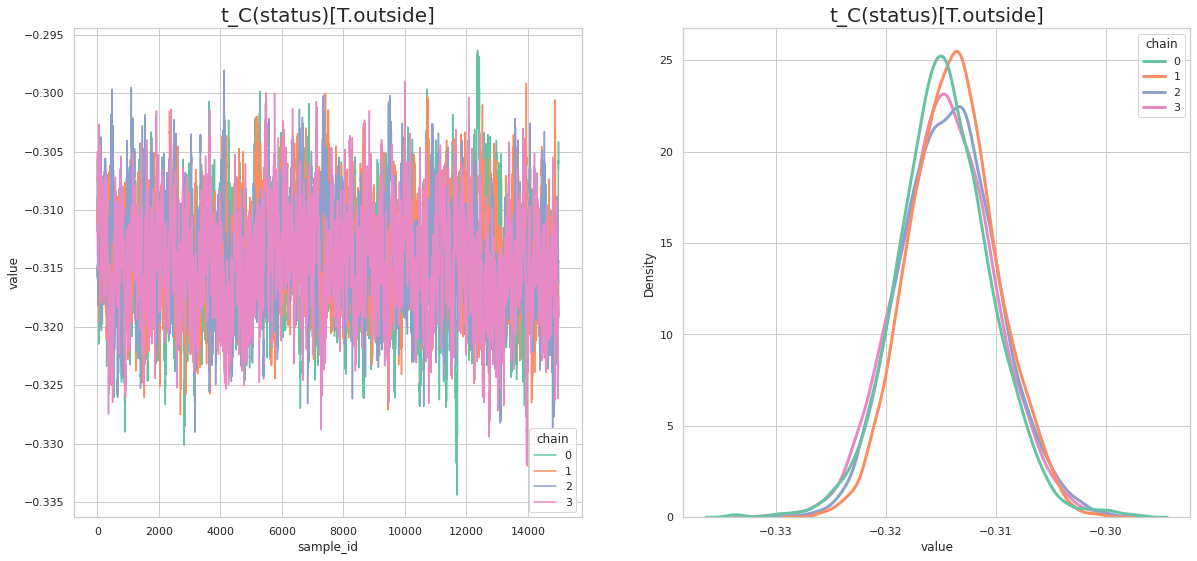

t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


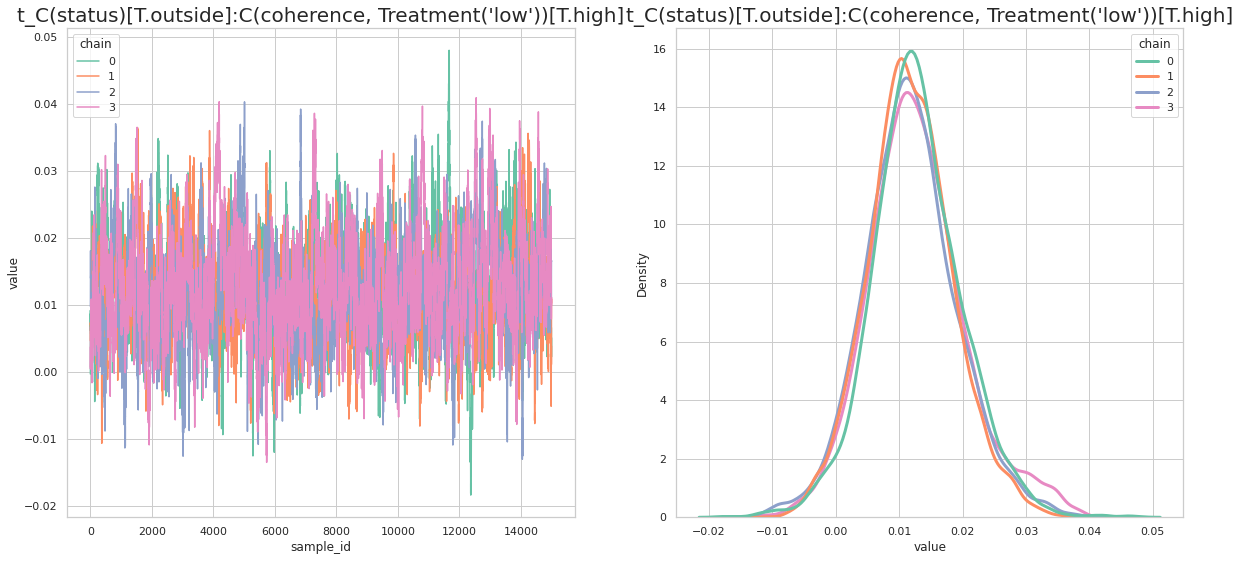

t_C(status)[T.outside]:C(cue)[T.valid]


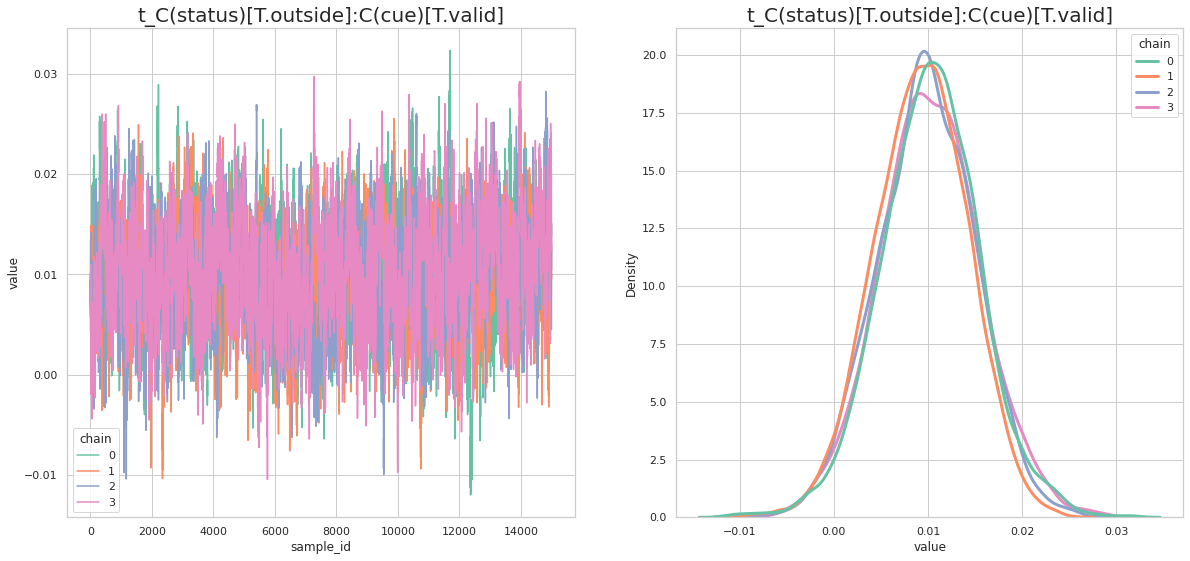

t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


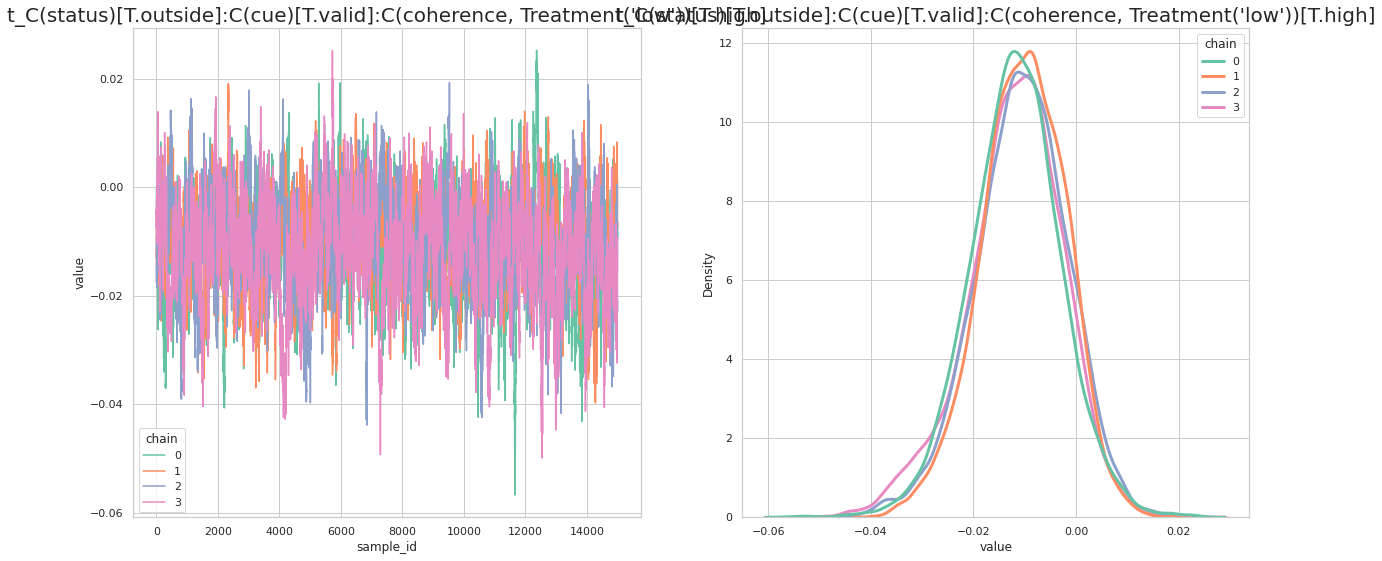

t_Intercept


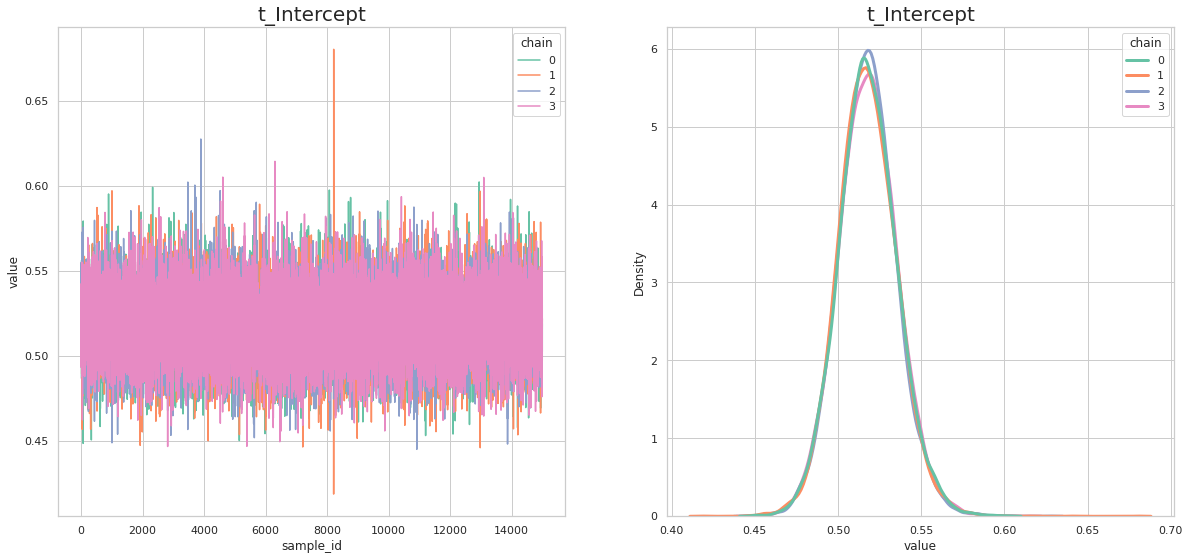

t_Intercept_std


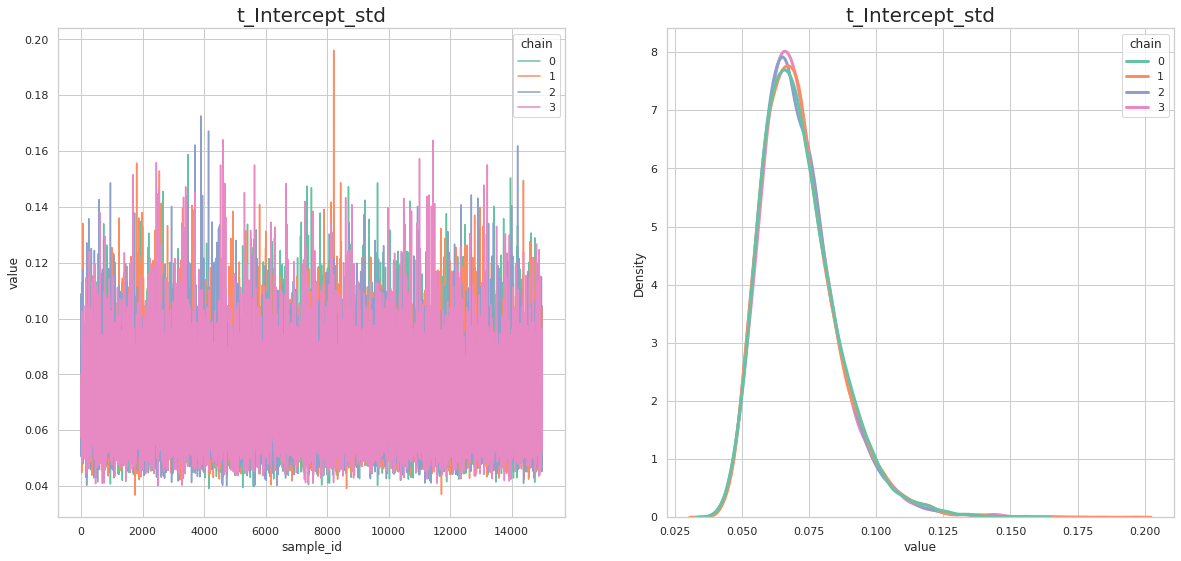

In [57]:
plot_grp_trace(models=M3s, param='t')

#### Posterior predictive analysis

In [27]:
M1s[0].plot_posterior_predictive()

<Figure size 576x432 with 0 Axes>

#### R-hat convergence statistic

In [28]:
M1s_r_hat = hddm.analyze.gelman_rubin(M1s)
M2s_r_hat = hddm.analyze.gelman_rubin(M2s)
M3s_r_hat = hddm.analyze.gelman_rubin(M3s)

# save Categ_R_hat_vtz
with open('M1s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M1s_r_hat.items())
    
with open('M2s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M2s_r_hat.items())
    
with open('M3s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M3s_r_hat.items())

### Model comparison

Assume that all three models are convergent, now we need to compare these three models and decide which is the best model.

#### Deviance information criterion (DIC)

In [29]:
print("DIC of models 1: %f" % M1s_comb.dic)
print("DIC of models 2: %f" % M2s_comb.dic)
print("DIC of models 3: %f" % M3s_comb.dic)

DIC of models 1: 17118.067158
DIC of models 1: 8690.493477
DIC of models 1: 8695.295318


#### LOO and WAIC

loo & WAIC: https://discourse.pymc.io/t/calculating-waic-for-models-with-multiple-likelihood-functions/4834/2

data structure of ArviZ:
https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz

#### Posterior predictive check

In [30]:
ppc_data_1 = hddm.utils.post_pred_gen(M1s_comb)
ppc_data_2 = hddm.utils.post_pred_gen(M2s_comb)
ppc_data_3 = hddm.utils.post_pred_gen(M3s_comb)

 [--------------------117%--------------------] 20 of 17 complete in 15923.6 sec

In [35]:
ppc_compare_1 = hddm.utils.post_pred_stats(df, ppc_data_1)
ppc_compare_2 = hddm.utils.post_pred_stats(df, ppc_data_2)
ppc_compare_3 = hddm.utils.post_pred_stats(df, ppc_data_3)

In [36]:
print(ppc_compare_1)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.524057  0.522710  0.056725  1.813414e-06  0.003220     True   
mean_ub   0.700034  0.640382  0.119173  3.558345e-03  0.017760     True   
std_ub    0.767739  0.365519  0.095701  1.617816e-01  0.170940    False   
10q_ub    0.303661  0.310702  0.066885  4.958226e-05  0.004523     True   
30q_ub    0.458311  0.408699  0.076457  2.461327e-03  0.008307     True   
50q_ub    0.593837  0.530766  0.096973  3.977958e-03  0.013382     True   
70q_ub    0.716727  0.716190  0.137167  2.874083e-07  0.018815     True   
90q_ub    1.002137  1.113767  0.234958  1.246128e-02  0.067666     True   
mean_lb  -0.710871 -0.652258  0.134483  3.435528e-03  0.021521     True   
std_lb    0.721856  0.366662  0.097286  1.261632e-01  0.135627    False   
10q_lb    0.305616  0.318381  0.077302  1.629651e-04  0.006139     True   
30q_lb    0.448136  0.419

In [37]:
print(ppc_compare_2)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.524057  0.523232  0.051710  6.810688e-07  0.002675     True   
mean_ub   0.700034  0.632844  0.113957  4.514473e-03  0.017501     True   
std_ub    0.767739  0.276927  0.064724  2.408965e-01  0.245086    False   
10q_ub    0.303661  0.307495  0.081086  1.470270e-05  0.006590     True   
30q_ub    0.458311  0.481393  0.094801  5.327502e-04  0.009520     True   
50q_ub    0.593837  0.601517  0.096341  5.897530e-05  0.009341     True   
70q_ub    0.716727  0.721275  0.123532  2.069183e-05  0.015281     True   
90q_ub    1.002137  0.978842  0.190761  5.426853e-04  0.036933     True   
mean_lb  -0.710871 -0.653820  0.131192  3.254778e-03  0.020466     True   
std_lb    0.721856  0.279723  0.066800  1.954823e-01  0.199945    False   
10q_lb    0.305616  0.324116  0.093946  3.422495e-04  0.009168     True   
30q_lb    0.448136  0.500

In [38]:
print(ppc_compare_3)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.524057  0.522070  0.051482  0.000004  0.002654     True   
mean_ub   0.700034  0.634719  0.113853  0.004266  0.017229     True   
std_ub    0.767739  0.276653  0.064358  0.241166  0.245308    False   
10q_ub    0.303661  0.308578  0.081179  0.000024  0.006614     True   
30q_ub    0.458311  0.485779  0.094004  0.000754  0.009591     True   
50q_ub    0.593837  0.603288  0.096551  0.000089  0.009411     True   
70q_ub    0.716727  0.722550  0.123750  0.000034  0.015348     True   
90q_ub    1.002137  0.980660  0.190752  0.000461  0.036847     True   
mean_lb  -0.710871 -0.651530  0.129972  0.003521  0.020414     True   
std_lb    0.721856  0.279599  0.066544  0.195592  0.200019    False   
10q_lb    0.305616  0.322897  0.093199  0.000299  0.008985     True   
30q_lb    0.448136  0.496383  0.107026  0.002328  0.013782     True   
50q_lb

#### Plot the posterior prediction (w/ the observed data)

In [39]:
M3s[0].print_stats()

                                                                                     mean         std         2.5q          25q          50q         75q       97.5q       mc err
a                                                                                 1.06979   0.0374056     0.998346      1.04531      1.06884     1.09333     1.14629  0.000381268
a_std                                                                             0.14883   0.0315315      0.10224     0.126825     0.144252    0.165285     0.22438  0.000381003
a_subj.1                                                                         0.900445    0.026135     0.851788     0.882578     0.899798    0.917624    0.953755  0.000474443
a_subj.2                                                                         0.975566    0.025883     0.927183     0.957832     0.974822    0.992477     1.02801    0.0004314
a_subj.3                                                                           1.0615    0.021472      1.0

### Interepreting parameters and inference

Now assume that we get the best fitted model (M3), and we will then make statistical inference based on that model.

How to interprete the effect based on experimental design is beyond the scope of current primer. Essentially, the `HDDMRegressor` module is bulding a hierarchical model, therefore, interested readers and refer some article on linear regression with categorical vairable and their intereactions. (e.g., a blogpost [here](https://genomicsclass.github.io/book/pages/interactions_and_contrasts.html))

In the current models, we Let's look at the experimental design and the model again:

The experimental design is 2 by 2 by 2, thus 8 conditions, the models is:

---
For model without interaction:

* $v \sim cue + coherence + status, t \sim cue + coherence + status$

Thus for both `v` and `t`, we have intercept and three main effect. Because we did not include interaction terms, we are assuming that  the effects are additive.

To get the estimation for each condition, we need to use the available estimates to calculate the conditions.


`t_intercept`: Inside + invalid + high

`t_intercept` + `t_C(status)[T.outside]`: **Outside** + invalid + high

`t_intercept` + `t_C(cue)[T.valid]`: Inside + **valid** + high

`t_intercept` + `t_C(cue)[T.valid]` + `t_C(status)[T.outside]`: **Outside** + **valid** + high

`t_intercept` + `t_C(coherence)[T.low]`: Inside + invalid + **low**

`t_intercept` + `t_C(coherence)[T.low]` + `t_C(status)[T.outside]`: **Outside** + invalid + **low**

`t_intercept` + `t_C(coherence)[T.low]` + `t_C(cue)[T.valid]`: Inside + **valid** + **low**

`t_intercept` + `t_C(coherence)[T.low]`+ `t_C(cue)[T.valid]` + `t_C(status)[T.outside]`: **Outside** + **valid** + **low**

---


---
For model with interaction:

* $v \sim cue * coherence (Treatment('low'))* status$
* $t \sim cue * coherence(Treatment('low')) * status$

Thus for both `v` and `t`, we have intercept and three main effect. Because we did not include interaction terms, we are assuming that  the effects are additive.

To get the estimation for each condition, we need to use the available estimates to calculate the conditions.


`t_intercept`: Inside + invalid + low

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]`: Inside + invalid + **high**

`t_intercept` + `t_C(status)[T.outside]`: **Outside** + invalid + low

`t_intercept` + `t_C(cue)[T.valid]`: Inside + **valid** + low


`t_intercept` + `t_C(cue)[T.valid]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(cue)[T.valid] `: **Outside** + **valid** + low

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high] `: **Outside** + invalid + **high**

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]` + `t_C(cue)[T.valid]` + `t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]`: Inside + **valid** + **high**

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]`+ `t_C(cue)[T.valid]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]`: **Outside** + **valid** + **high**

---

In [40]:
df_grp_traces = []
for i in range(4):
    df_m = M3s[i]
    df_grp_trace = df_m.get_group_traces()
    df_grp_trace['chain'] = i
    print('chain', i, df_grp_trace.shape)
    df_grp_traces.append(df_grp_trace)
    
df_grp_traces = pd.concat(df_grp_traces)

# select the columns included that parameter
filter_col = [col for col in df_grp_traces if col.startswith('v')] # filter column names contains v
# filter_col = [col for col in df_grp_traces_m1 if 'std' not in col] # filter column names contains v

filter_col = [col for col in filter_col if 'std' not in col] # filter the std column

filter_col.append('chain') # add the chain column to the data

#df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
df_tmp = df_grp_traces.loc[:, filter_col]
df_tmp["sample_id"] = df_tmp.index

df_tmp.head()

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)


v_Intercept  v_C(status)[T.outside]  v_C(cue)[T.valid]  \
0    -0.062468               -0.053487           0.098591   
1    -0.007200               -0.114474           0.156211   
2    -0.028582               -0.122924           0.102577   
3     0.017700               -0.138362           0.089363   
4    -0.083093               -0.002991           0.097507   

   v_C(coherence, Treatment('low'))[T.high]  \
0                                  0.022564   
1                                  0.022045   
2                                 -0.054772   
3                                 -0.055203   
4                                 -0.051199   

   v_C(status)[T.outside]:C(cue)[T.valid]  \
0                                0.003570   
1                               -0.004450   
2                                0.018532   
3                                0.120489   
4                                0.123399   

   v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]  \
0                                           0.103568               
1                                           0.090007               
2                                           0.120733               
3                                           0.083329               
4                                          -0.058702               

   v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.148528          
1                                          -0.156008          
2                                          -0.116764          
3                                          -0.125658          
4                                          -0.011792          

   v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.067038                               
1                                          -0.074140                               
2                                          -0.019971                               
3                                          -0.150149                               
4                                          -0.036739                               

   chain  sample_id  
0      0          0  
1      0          1  
2      0          2  
3      0          3  
4      0          4

In [51]:
df_tmp['Inside_Invalid_Low']  = df_tmp['v_Intercept']
df_tmp['Outside_Invalid_Low'] = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(status)[T.outside]"]
df_tmp['Inside_Valid_Low']    = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(cue)[T.valid]"]
df_tmp['Inside_Invalid_High'] = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(coherence, Treatment('low'))[T.high]"]

df_tmp['Outside_Valid_Low']    = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(status)[T.outside]"] \
                                 + df_tmp["v_C(cue)[T.valid]"] \
                                 + df_tmp["v_C(status)[T.outside]:C(cue)[T.valid]"]

df_tmp['Outside_Invalid_High'] = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                                 + df_tmp["v_C(status)[T.outside]"] \
                                 + df_tmp["v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]"]

df_tmp['Inside_Valid_High']    = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                                 + df_tmp["v_C(cue)[T.valid]"] \
                                 + df_tmp["v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]

df_tmp['Outside_Valid_High'] = df_tmp['v_Intercept']  \
                               + df_tmp["v_C(status)[T.outside]"] \
                               + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                               + df_tmp["v_C(cue)[T.valid]"] \
                               + df_tmp["v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
df_tmp.head()

v_Intercept  v_C(status)[T.outside]  v_C(cue)[T.valid]  \
0    -0.062468               -0.053487           0.098591   
1    -0.007200               -0.114474           0.156211   
2    -0.028582               -0.122924           0.102577   
3     0.017700               -0.138362           0.089363   
4    -0.083093               -0.002991           0.097507   

   v_C(coherence, Treatment('low'))[T.high]  \
0                                  0.022564   
1                                  0.022045   
2                                 -0.054772   
3                                 -0.055203   
4                                 -0.051199   

   v_C(status)[T.outside]:C(cue)[T.valid]  \
0                                0.003570   
1                               -0.004450   
2                                0.018532   
3                                0.120489   
4                                0.123399   

   v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]  \
0                                           0.103568               
1                                           0.090007               
2                                           0.120733               
3                                           0.083329               
4                                          -0.058702               

   v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.148528          
1                                          -0.156008          
2                                          -0.116764          
3                                          -0.125658          
4                                          -0.011792          

   v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.067038                               
1                                          -0.074140                               
2                                          -0.019971                               
3                                          -0.150149                               
4                                          -0.036739                               

   chain  sample_id  Inside_Invalid_Low  Outside_Invalid_Low  \
0      0          0           -0.062468            -0.115954   
1      0          1           -0.007200            -0.121674   
2      0          2           -0.028582            -0.151507   
3      0          3            0.017700            -0.120662   
4      0          4           -0.083093            -0.086084   

   Inside_Valid_Low  Inside_Invalid_High  Outside_Valid_Low  \
0          0.036124            -0.039904          -0.013792   
1          0.149011             0.014845           0.030087   
2          0.073995            -0.083354          -0.030398   
3          0.107063            -0.037503           0.089189   
4          0.014414            -0.134292           0.134822   

   Outside_Invalid_High  Inside_Valid_High  Outside_Valid_High  
0              0.010177          -0.089841           -0.061837  
1             -0.009622           0.015048           -0.017558  
2             -0.085546          -0.097541           -0.123672  
3             -0.092536          -0.073798           -0.236651  
4             -0.195986          -0.048577           -0.076516

In [52]:
df_tmp2 = df_tmp.iloc[:, 8:].copy()
df_tmp2.head()

chain  sample_id  Inside_Invalid_Low  Outside_Invalid_Low  \
0      0          0           -0.062468            -0.115954   
1      0          1           -0.007200            -0.121674   
2      0          2           -0.028582            -0.151507   
3      0          3            0.017700            -0.120662   
4      0          4           -0.083093            -0.086084   

   Inside_Valid_Low  Inside_Invalid_High  Outside_Valid_Low  \
0          0.036124            -0.039904          -0.013792   
1          0.149011             0.014845           0.030087   
2          0.073995            -0.083354          -0.030398   
3          0.107063            -0.037503           0.089189   
4          0.014414            -0.134292           0.134822   

   Outside_Invalid_High  Inside_Valid_High  Outside_Valid_High  
0              0.010177          -0.089841           -0.061837  
1             -0.009622           0.015048           -0.017558  
2             -0.085546          -0.097541           -0.123672  
3             -0.092536          -0.073798           -0.236651  
4             -0.195986          -0.048577           -0.076516

In [53]:
df_melt = pd.melt(df_tmp2,
                  id_vars=['sample_id', 'chain'],
#                   value_vars=filter_col[:-1],
                  var_name='cond',
                  value_name='value')
df_melt.head()

sample_id  chain                cond     value
0          0      0  Inside_Invalid_Low -0.062468
1          1      0  Inside_Invalid_Low -0.007200
2          2      0  Inside_Invalid_Low -0.028582
3          3      0  Inside_Invalid_Low  0.017700
4          4      0  Inside_Invalid_Low -0.083093

In [54]:
df_melt[['Status', 'Cue', 'Coherence']] = df_melt['cond'].str.split('_', expand=True)
#df_melt['condition'] = df_melt['condition'].str.rstrip(')')
#df_melt[['Coherence', 'Cue', 'Status']] = df_melt['condition'].str.split(pat='.', expand=True)

df_melt = df_melt[['sample_id', 'chain', 'Status', 'Coherence', 'Cue', 'value']]
df_melt.head()

sample_id  chain  Status Coherence      Cue     value
0          0      0  Inside       Low  Invalid -0.062468
1          1      0  Inside       Low  Invalid -0.007200
2          2      0  Inside       Low  Invalid -0.028582
3          3      0  Inside       Low  Invalid  0.017700
4          4      0  Inside       Low  Invalid -0.083093

In [55]:
df_melt_p = df_melt
df_melt_p['cond'] = df_melt_p['Cue'] + '_' + df_melt_p['Coherence']
df_melt_p.head()

sample_id  chain  Status Coherence      Cue     value         cond
0          0      0  Inside       Low  Invalid -0.062468  Invalid_Low
1          1      0  Inside       Low  Invalid -0.007200  Invalid_Low
2          2      0  Inside       Low  Invalid -0.028582  Invalid_Low
3          3      0  Inside       Low  Invalid  0.017700  Invalid_Low
4          4      0  Inside       Low  Invalid -0.083093  Invalid_Low

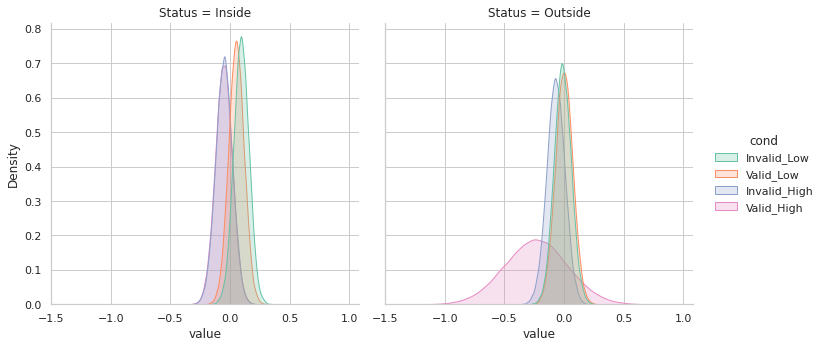

In [56]:
sns.displot(df_melt_p, x="value", col="Status", hue='cond', kind='kde', fill=True)